Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import missingno as msno
from pandas_profiling import ProfileReport
from sklearn import decomposition
from sklearn import preprocessing
from mesfonctions import scatter_plot
from mesfonctions import display_scree_plot
from mesfonctions import display_circles

In [131]:
# pour développement only - cellule à supprimer du notebook final
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)
# from mesfonctions import xxx

## Gestion des paramètres d'affichage de Jupyter

In [132]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 165 sur ma config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

# Notes

Gross floor area (GFA) - The total floor area contained within the building measured to the external face of the external walls. Mesuré en square feet.  

1 sq foot = 0.092 m²  

ENERGYSTARScore : score de 1 à 100. Le score correspond au centile dans lequel le bâtiment se trouve.  

Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area.  

1 acre = 4047 m²  

1 British thermal unit (kBtu) per square foot = 3.2 kW.h/m²  

1 kBtu = 0.29 kW.h  

SPD beats : rondes de la police (SPD = Seattle PD)

WN : weather normalized. Site Energy Use the property would have consumed during 30-year average weather conditions.

TotalGHGEmissions : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 

# Récupération des données pour 2015 et 2016

## Lecture des fichiers .json (metadata)

### Fichier pour 2015

#### Affichage intégral du json :

In [133]:
with open('socrata_metadata_2015-building-energy-benchmarking.json') as f:
  df2015metadata = json.load(f)
print(json.dumps(df2015metadata, indent = 4, sort_keys=False))

{
    "id": "h7rm-fz6m",
    "name": "2015 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "http://www.seattle.gov/environment",
    "averageRating": 0,
    "createdAt": 1492461362,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\r\nPer Ordinance (125000), starting 

Sections du json :

In [134]:
df2015metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [135]:
nbcol = len(df2015metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 47


In [136]:
for column in range(len(df2015metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [137]:
liste_var_2015 = []
for column in range(nbcol):
    name = df2015metadata["columns"][column]['name']
    liste_var_2015.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2015metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Description non disponible
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name.
********** Colonne 5 : TaxParcelIdentificationNumber **********
	
Property King County PIN
********** Colonne 6 : Location **********
Description non disponible
********** Colonne 7 : CouncilDistrictCode **********
Property City of Seattle council district.
********** Colonne 8 : Neighborhood **********

### Fichier pour 2016

#### Affichage intégral du json :

In [138]:
with open('socrata_metadata_2016-building-energy-benchmarking.json') as f:
  df2016metadata = json.load(f)
print(json.dumps(df2016metadata, indent = 4, sort_keys=False))

{
    "id": "2bpz-gwpy",
    "name": "2016 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "https://www.seattle.gov/energybenchmarking",
    "averageRating": 0,
    "createdAt": 1521070051,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\nPer Ordinance (125000), sta

Sections du json :

In [139]:
df2016metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowIdentifierColumnId', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [140]:
nbcol = len(df2016metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 46


In [141]:
for column in range(len(df2016metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [142]:
liste_var_2016 = []
for column in range(nbcol):
    name = df2016metadata["columns"][column]['name']
    liste_var_2016.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2016metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Calendar year (January-December) represented by each data record.
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name as entered in EPA’s Portfolio Manager.
********** Colonne 5 : Address **********
Property street address
********** Colonne 6 : City **********
Property city
********** Colonne 7 : State **********
Property state
********** Colonne 8 : ZipCode **********
Property zi

### Différences entre les variables de 2015 et 2016

Listes des variables de 2015, de 2016, et concaténation de ces deux listes

In [143]:
liste_var_2015_2016 = liste_var_2016 + liste_var_2015
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_var_2015_2016 = list(dict.fromkeys(liste_var_2015_2016))
# impression des variables et des années de disponibilité
for var in liste_var_2015_2016:
    print(var, end=' : ')
    if var in liste_var_2015:
        print(" 2015", end='')
    if var in liste_var_2016:
        print(" 2016", end='')
    print()

OSEBuildingID :  2015 2016
DataYear :  2015 2016
BuildingType :  2015 2016
PrimaryPropertyType :  2015 2016
PropertyName :  2015 2016
Address :  2016
City :  2016
State :  2016
ZipCode :  2016
TaxParcelIdentificationNumber :  2015 2016
CouncilDistrictCode :  2015 2016
Neighborhood :  2015 2016
Latitude :  2016
Longitude :  2016
YearBuilt :  2015 2016
NumberofBuildings :  2015 2016
NumberofFloors :  2015 2016
PropertyGFATotal :  2015 2016
PropertyGFAParking :  2015 2016
PropertyGFABuilding(s) :  2015 2016
ListOfAllPropertyUseTypes :  2015 2016
LargestPropertyUseType :  2015 2016
LargestPropertyUseTypeGFA :  2015 2016
SecondLargestPropertyUseType :  2015 2016
SecondLargestPropertyUseTypeGFA :  2015 2016
ThirdLargestPropertyUseType :  2015 2016
ThirdLargestPropertyUseTypeGFA :  2015 2016
YearsENERGYSTARCertified :  2015 2016
ENERGYSTARScore :  2015 2016
SiteEUI(kBtu/sf) :  2015 2016
SiteEUIWN(kBtu/sf) :  2015 2016
SourceEUI(kBtu/sf) :  2015 2016
SourceEUIWN(kBtu/sf) :  2015 2016
SiteEnerg

## Conversion des fichiers .csv en dataframe pandas

In [144]:
df2015 = pd.read_csv('2015-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)

df2016 = pd.read_csv('2016-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)


### Création des colonnes Latitude et Longitude pour le df2015

In [145]:
import ast     
df2015["Latitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['latitude']))     # ast.literal_eval(x) convertit le string x en dictionnaire
df2015["Longitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['longitude'])) 

In [146]:
df2015["Latitude"][0]

47.61219025

## Affichage de quelques lignes des dataframes

In [147]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
#     display(df2015.head())
    display(df2015.loc[[4]])
#     display(df2015.loc[4:5000])
#     display(df2015.tail())

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
4  WARWICK SEATTLE HOTEL                     659000970   

                                                                                                                                                     Location  \
4  {'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{"address": "401 LENORA ST", "city": "SEATTLE", "state": "WA", "zip": "98121"}'}   

   CouncilDistrictCode Neighborhood  YearBuilt  NumberofBuildings  \
4                    7     DOWNTOWN       1980                  1   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
4            18.0            119890               12460   

   PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
4                  107430  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
4                      NaN             67.0             120.1   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
4               122.1               228.8                 227.1   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
4           14829099.0             15078243.0             0.0   

   Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
4         1777841.0          6066245.0             87631.0         8763105.0   

   OtherFuelUse(kBtu)  GHGEmissions(MetricTonsCO2e)  \
4                 0.0                         507.7   

   GHGEmissionsIntensity(kgCO2e/ft2) DefaultData Comment ComplianceStatus  \
4                               4.02          No     NaN        Compliant   

  Outlier  2010 Census Tracts  \
4     NaN                 NaN   

   Seattle Police Department Micro Community Policing Plan Areas  \
4                                                           56.0   

   City Council Districts  SPD Beats  Zip Codes   Latitude   Longitude  
4                     NaN       31.0      19576  47.613754 -122.340924

In [148]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(df2016.head())
#     display(df2016.loc[[4]])
#     display(df2016.loc[4:5000])
    display(df2016.tail())

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
3371                Horticulture building  1600 S Dakota St  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
3371      NaN                    1624049080                    2   
3372      NaN                    3558300000                    2   
3373      NaN                    1794501150                    7   
3374      NaN                    7883603155                    1   
3375      NaN                    7857002030                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
3371       GREATER DUWAMISH  47.56722 -122.31154       1990   
3372               DOWNTOWN  47.59625 -122.32283       2004   
3373  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374       GREATER DUWAMISH  47.52832 -122.32431       1989   
3375       GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3371                1.0               1             12294                   0   
3372                1.0               1             16000                   0   
3373                1.0               1             13157                   0   
3374                1.0               1             14101                   0   
3375                1.0               1             18258                   0   

      PropertyGFABuilding(s)  \
3371                   12294   
3372                   16000   
3373                   13157   
3374                   14101   
3375                   18258   

                                                                         ListOfAllPropertyUseTypes  \
3371                                                                                        Office   
3372                                                                            Other - Recreation   
3373                             Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool   
3374  Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare   
3375  Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other - Recreation                     8271.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3371                             NaN                              NaN   
3372                             NaN                              NaN   
3373  Fitness Center/Health Club/Gym                           5574.0   
3374  Fitness Center/Health Club/Gym                           6501.0   
3375  Fitness Center/Health Club/Gym                           8000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3371                         NaN                             NaN   
3372                         NaN                             NaN   
3373               Swimmi

## Statistiques rudimentaires

In [149]:
length = len(df2015)
print("length df2015 =", length)
length = len(df2016)
print("length df2016 =", length)

length df2015 = 3340
length df2016 = 3376


In [150]:
df2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 49 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [151]:
df2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [152]:
df2015.describe()

OSEBuildingID  DataYear  CouncilDistrictCode    YearBuilt  \
count    3340.000000    3340.0          3340.000000  3340.000000   
mean    20522.168263    2015.0             4.450898  1967.624850   
std     11511.515874       0.0             2.127203    32.949847   
min         1.000000    2015.0             1.000000  1900.000000   
25%     19921.750000    2015.0             3.000000  1947.000000   
50%     22977.000000    2015.0             4.000000  1973.000000   
75%     25748.000000    2015.0             7.000000  1996.000000   
max     50059.000000    2015.0             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        3340.000000     3332.000000      3.340000e+03   
mean            1.035629        4.682173      9.077289e+04   
std             0.784463        5.458460      1.493058e+05   
min             1.000000        0.000000      2.000000e+04   
25%             1.000000        2.000000      2.848700e+04   
50%             1.000000        4.000000      4.385500e+04   
75%             1.000000        5.000000      8.842800e+04   
max            39.000000       99.000000      2.200000e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         3340.000000            3.340000e+03               3.204000e+03   
mean         11054.032335            7.971886e+04               7.488154e+04   
std          35296.330507            1.292314e+05               1.236249e+05   
min             -3.000000           -5.055000e+04               5.872000e+03   
25%              0.000000            2.668300e+04               2.500000e+04   
50%              0.000000            4.132600e+04               3.900000e+04   
75%           4304.250000            7.872600e+04               7.206750e+04   
max         512608.000000            2.200000e+06               1.719643e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1559.000000                      560.000000   
mean                      27675.646568                    10755.708929   
std                       52480.843425                    22618.529737   
min                           0.000000                        0.000000   
25%                        4959.000000                     2385.250000   
50%                       10600.000000                     5019.500000   
75%                       26224.500000                    10275.000000   
max                      686750.000000                   303910.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2560.000000       3330.000000         3330.000000   
mean         67.894141         53.626126           57.586547   
std          27.154057         53.893311           55.604963   
min           1.000000          0.000000            0.000000   
25%          51.750000         27.300000           29.700000   
50%          76.000000         37.400000           40.900000   
75%          90.000000         59.875000           65.575000   
max         100.000000        800.600000          800.600000   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3330.000000           3330.000000         3.330000e+03   
mean           132.779730            138.936036         4.983106e+06   
std            131.943223            131.359121         1.375330e+07   
min             -2.000000             -2.000000         0.000000e+00   
25%             73.500000             80.300000         9.139300e+05   
50%             95.000000            102.800000         1.776219e+06   
75%            143.900000            151.275000         4.044277e+06   
max           2511.100000           2511.000000         2.958126e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           3.330000e+03    3.330000e+03      3.330000e+03   
mean            5.203055e+06    2.502851e+05      1.017897e+06   
std             1.40075

In [153]:
df2016.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

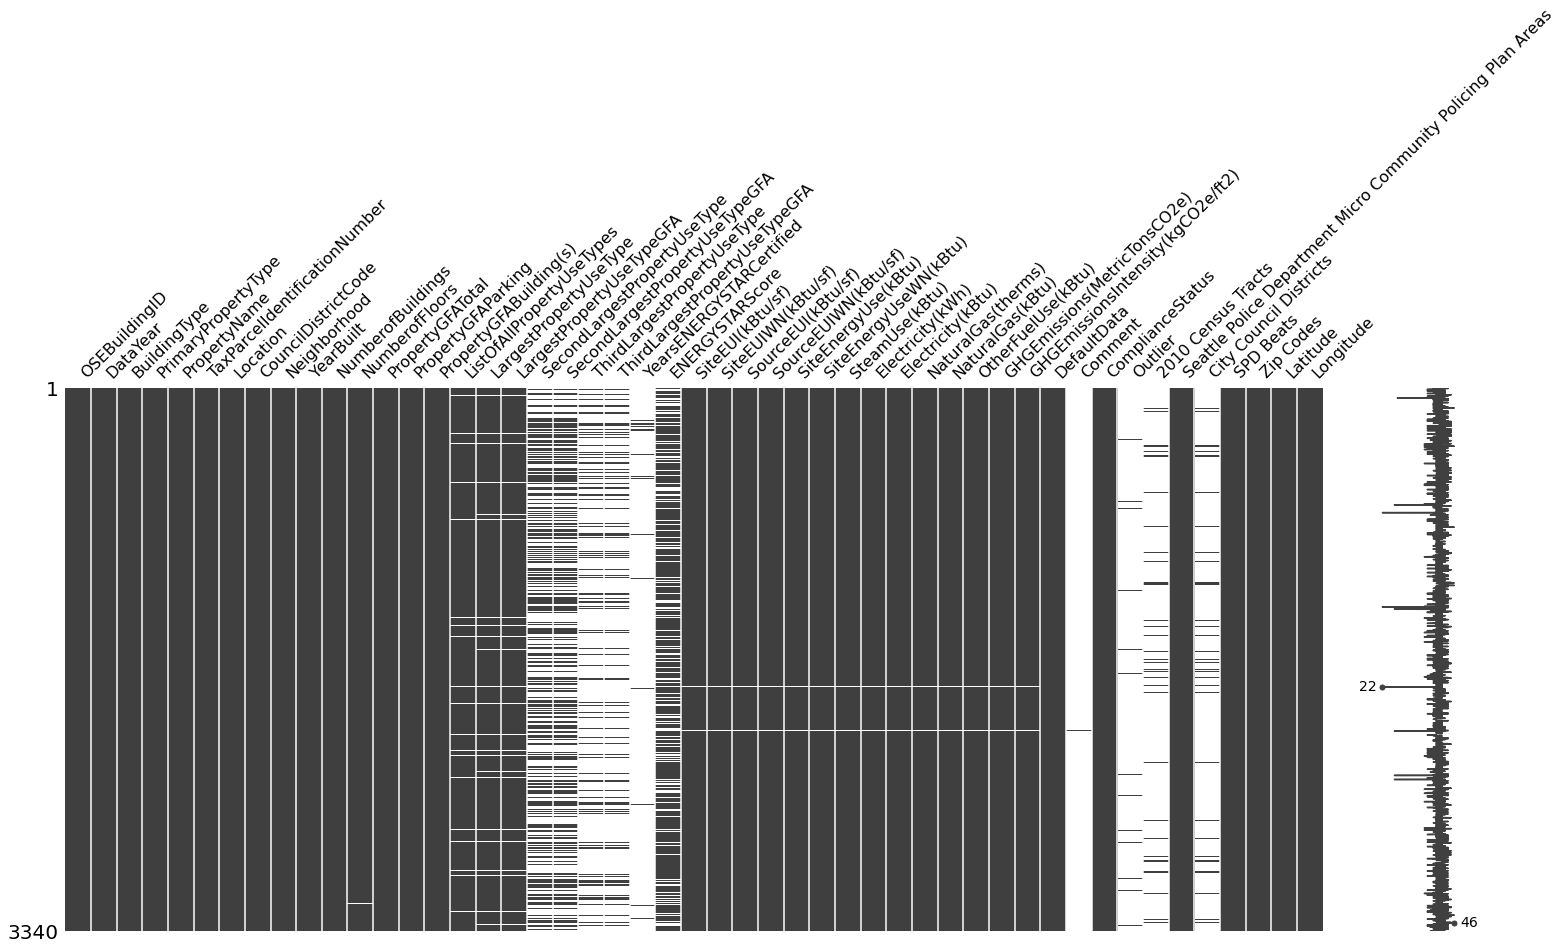

In [26]:
msno.matrix(df2015);

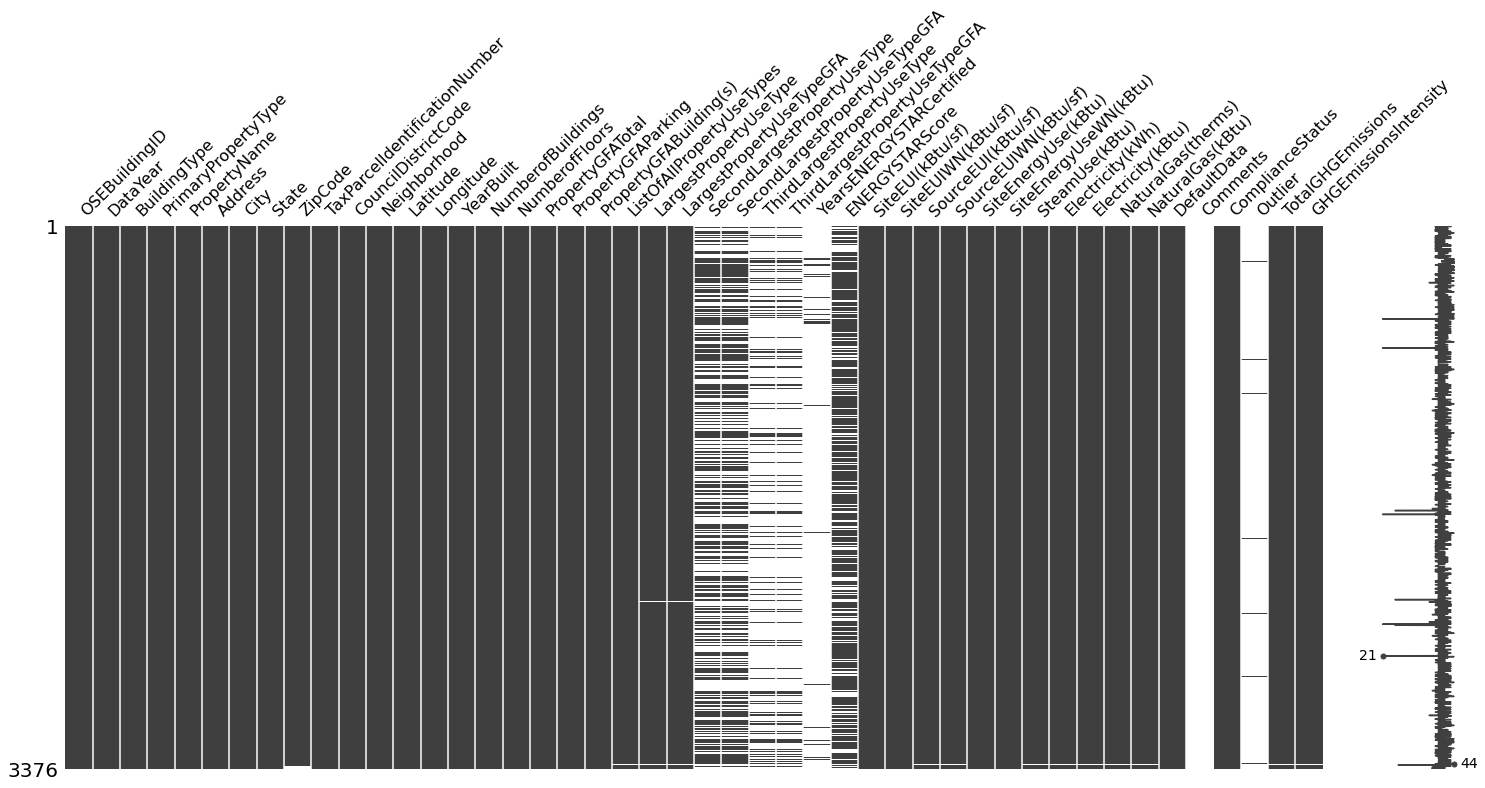

In [27]:
msno.matrix(df2016);

## Analyse exploratoire avec pandas_profiling (minimaliste)

In [154]:
profile = False
if profile:
    profile = ProfileReport(df2015, title='df2015 Pandas Profiling Report', minimal=True)
profile

False

In [155]:
profile = False
if profile:
    profile = ProfileReport(df2016, title='df2016 Pandas Profiling Report', minimal=True)
profile

False

# Comparaison des datasets 2015 vs 2016

## Recherche de bâtiments en doublons

### Recherche de doublons intra 2015

In [156]:
len(df2015['OSEBuildingID'].unique())

3340

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2015, ce qui indique une absence de doublons.

### Recherche de doublons intra 2016

In [157]:
len(df2016['OSEBuildingID'].unique())

3376

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2016, ce qui indique une absence de doublons.

### Recouvrement entre les datasets de 2015 et 2016 ; et de la pertinence de travailler avec les deux datasets réunis

On compare les OSEBuildingID du df2015 avec ceux du df2016.

In [158]:
Set_OSEBuildingID_2015 = set(df2015['OSEBuildingID'])
Set_OSEBuildingID_2016 = set(df2016['OSEBuildingID'])

#### Union 2015 et 2016

In [159]:
len(Set_OSEBuildingID_2015 | Set_OSEBuildingID_2016)

3432

#### Intersection 2015 et 2016

In [160]:
len(Set_OSEBuildingID_2015 & Set_OSEBuildingID_2016)

3284

#### Bâtiments de 2015 non renseignés en 2016

In [161]:
len(Set_OSEBuildingID_2015 - Set_OSEBuildingID_2016)

56

#### Bâtiments de 2016 non renseignés en 2015

In [162]:
len(Set_OSEBuildingID_2016 - Set_OSEBuildingID_2015)

92

#### Conclusion sur le recouvrement

En joignant les datasets 2015 et 2016, on passerait de 3376 à 3432 bâtiments dans un nouveau dataset (soit un gain de 1.7%). Le gain en nb de bâtiments est trop faible pour prendre le risque de joindre des données qui ont disparu pour une raison non déterminée entre 2015 et 2016.  
Pour notre mission de prédiction de données, nous ne travaillerons donc qu'avec le dataset le plus récent : celui de 2016.  

# Nettoyage (df1 = données 2016 post nettoyage)

## Suppression de variables

Raisons des suppressions de colonnes :
- modalité unique (DataYear, NumberofBuildings)
- modalité différente pour chaque bâtiment (PropertyName, TaxParcelIdentificationNumber, Location, )
- trop peu de bâtiments renseignés (YearsENERGYSTARCertified, ComplianceStatus, Outlier)
- non pertinent pour notre problème (DefaultData, Comment)
- data leakage ( / ) : donnée qu'on ne devra pas exploiter dans le jeu de test.

In [163]:
liste_var_conservees = [
    'OSEBuildingID',
    # 'DataYear',     # modalité unique
    'BuildingType',
    'PrimaryPropertyType',
    # 'PropertyName',     # modalité différente pour chaque bâtiment
    # 'Address',     # non pertinent
    # 'City',     # modalité unique
    # 'State',     # modalité unique
    'ZipCode',
    # 'TaxParcelIdentificationNumber',     # modalité différente pour chaque bâtiment
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    # 'ListOfAllPropertyUseTypes',     # trop de modalités différentes pour chaque bâtiment  # redondances
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA',
    # 'YearsENERGYSTARCertified',     # trop peu de bâtiments renseignés
    'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    # 'DefaultData',     # non pertinent
    # 'Comments',     # non pertinent
    # 'ComplianceStatus',     # non pertinent
    # 'Outlier',     # non pertinent
    'TotalGHGEmissions',
    'GHGEmissionsIntensity',
    # 'Location',     # issu du dataset 2015. ; substitué par Longitude/Latitude
    # 'OtherFuelUse(kBtu)',     # non pertinent
    # 'GHGEmissions(MetricTonsCO2e)',     # issu du dataset 2015. Renommé TotalGHGEmissions dans le dataset 2016
    # 'GHGEmissionsIntensity(kgCO2e/ft2)',     # issu du dataset 2015. Renommé GHGEmissionsIntensity dans le dataset 2016
    # 'Comment',     # non pertinent
    # '2010 Census Tracts',          # non pertinent
    # 'Seattle Police Department Micro Community Policing Plan Areas',          # non pertinent
    # 'City Council Districts',     # issu du dataset 2015. Renommé CouncilDistrictCode dans le dataset 2016
    # 'SPD Beats'          # non pertinent
]

### Création de df1 (données de 2016 avec uniquement les variables conservées)

In [164]:
df1 = df2016[liste_var_conservees].copy()

In [165]:
df1

OSEBuildingID        BuildingType PrimaryPropertyType  ZipCode  \
0                 1      NonResidential               Hotel  98101.0   
1                 2      NonResidential               Hotel  98101.0   
2                 3      NonResidential               Hotel  98101.0   
3                 5      NonResidential               Hotel  98101.0   
4                 8      NonResidential               Hotel  98121.0   
...             ...                 ...                 ...      ...   
3371          50222  Nonresidential COS              Office      NaN   
3372          50223  Nonresidential COS               Other      NaN   
3373          50224  Nonresidential COS               Other      NaN   
3374          50225  Nonresidential COS  Mixed Use Property      NaN   
3375          50226  Nonresidential COS  Mixed Use Property      NaN   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
0                       7               DOWNTOWN  47.61220 -122.33799   
1                       7               DOWNTOWN  47.61317 -122.33393   
2                       7               DOWNTOWN  47.61393 -122.33810   
3                       7               DOWNTOWN  47.61412 -122.33664   
4                       7               DOWNTOWN  47.61375 -122.34047   
...                   ...                    ...       ...        ...   
3371                    2       GREATER DUWAMISH  47.56722 -122.31154   
3372                    2               DOWNTOWN  47.59625 -122.32283   
3373                    7  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784   
3374                    1       GREATER DUWAMISH  47.52832 -122.32431   
3375                    2       GREATER DUWAMISH  47.53939 -122.29536   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
1          1996                1.0              11            103566   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
4          1980                1.0              18            175580   
...         ...                ...             ...               ...   
3371       1990                1.0               1             12294   
3372       2004                1.0               1             16000   
3373       1974                1.0               1             13157   
3374       1989                1.0               1             14101   
3375       1938                1.0               1             18258   

      PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
0                      0                   88434                  Hotel   
1                  15064                   88502                  Hotel   
2                 196718                  759392                  Hotel   
3                      0                   61320                  Hotel   
4                  62000                  113580                  Hotel   
...                  ...                     ...                    ...   
3371                   0                   12294                 Office   
3372                   0                   16000     Other - Recreation   
3373                   0                   13157     Other - Recreation   
3374                   0                   14101     Other - Recreation   
3375                   0                   18258     Other - Recreation   

      LargestPropertyUseTypeGFA    SecondLargestPropertyUseType  \
0                       88434.0                             NaN   
1                       83880.0                         Parking   
2                      756493.0                             NaN   
3                       61320.0                             NaN   
4                      123445.0                         Parking   
...                         ...                             ...   
3371                    12294

## Suppression des bâtiments destinés à l’habitation 

### Exploration des variables qui classent le type de bâtiment

Notes : 
- SPS : Seattle Public schools  


In [166]:
df1['BuildingType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False)

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [167]:
df1['PrimaryPropertyType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Restaurant                      12
Refrigerated Warehouse          12
Laboratory                      10
Hospital                        10
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [168]:
df1['LargestPropertyUseType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Medical Office                                            41
Supermarket/Grocery Store                                 41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
Residence Hall/Dormitory

### Suppression via la variable 'BuildingType'

In [169]:
# Suppression des modalités 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'

# avant refactoring
# ser_bool = df1['BuildingType'] == 'Multifamily LR (1-4)') | (df1['BuildingType'] == 'Multifamily MR (5-9)') | (df1['BuildingType'] == 'Multifamily HR (10+)'

# après refactoring
ser_bool = df1['BuildingType'].isin(['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'])

df1 = df1[~ser_bool]

In [170]:
df1

OSEBuildingID        BuildingType PrimaryPropertyType  ZipCode  \
0                 1      NonResidential               Hotel  98101.0   
1                 2      NonResidential               Hotel  98101.0   
2                 3      NonResidential               Hotel  98101.0   
3                 5      NonResidential               Hotel  98101.0   
4                 8      NonResidential               Hotel  98121.0   
...             ...                 ...                 ...      ...   
3371          50222  Nonresidential COS              Office      NaN   
3372          50223  Nonresidential COS               Other      NaN   
3373          50224  Nonresidential COS               Other      NaN   
3374          50225  Nonresidential COS  Mixed Use Property      NaN   
3375          50226  Nonresidential COS  Mixed Use Property      NaN   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
0                       7               DOWNTOWN  47.61220 -122.33799   
1                       7               DOWNTOWN  47.61317 -122.33393   
2                       7               DOWNTOWN  47.61393 -122.33810   
3                       7               DOWNTOWN  47.61412 -122.33664   
4                       7               DOWNTOWN  47.61375 -122.34047   
...                   ...                    ...       ...        ...   
3371                    2       GREATER DUWAMISH  47.56722 -122.31154   
3372                    2               DOWNTOWN  47.59625 -122.32283   
3373                    7  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784   
3374                    1       GREATER DUWAMISH  47.52832 -122.32431   
3375                    2       GREATER DUWAMISH  47.53939 -122.29536   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
1          1996                1.0              11            103566   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
4          1980                1.0              18            175580   
...         ...                ...             ...               ...   
3371       1990                1.0               1             12294   
3372       2004                1.0               1             16000   
3373       1974                1.0               1             13157   
3374       1989                1.0               1             14101   
3375       1938                1.0               1             18258   

      PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
0                      0                   88434                  Hotel   
1                  15064                   88502                  Hotel   
2                 196718                  759392                  Hotel   
3                      0                   61320                  Hotel   
4                  62000                  113580                  Hotel   
...                  ...                     ...                    ...   
3371                   0                   12294                 Office   
3372                   0                   16000     Other - Recreation   
3373                   0                   13157     Other - Recreation   
3374                   0                   14101     Other - Recreation   
3375                   0                   18258     Other - Recreation   

      LargestPropertyUseTypeGFA    SecondLargestPropertyUseType  \
0                       88434.0                             NaN   
1                       83880.0                         Parking   
2                      756493.0                             NaN   
3                       61320.0                             NaN   
4                      123445.0                         Parking   
...                         ...                             ...   
3371                    12294

## Suppression de valeurs zéro

Plusieurs variables qui ne peuvent pas être nulles contiennent des valeurs à zéro.  
La liste suivante contient les variables que nous allons nettoyer.  
Les valeurs à zéro ont été remplacées par des NaN.

In [171]:
liste_var_nettoyees_zero = [
    'PropertyGFATotal',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
]

##### Fonction suppression_zeros()

In [172]:
def suppression_zeros(df):
    print(
        'Variable'.center(36, ' '), 
        'Nb de valeurs avant nettoyage'.center(33, ' '), 
        'Nb de remplacements NaN'.center(25, ' '), 
        '%remplacés'.center(11, ' '))
    print(''.center(36+33+25+11+4, '-'))

    for var in liste_var_nettoyees_zero:
        count_avant = df[var].count()
        df[var] = df[var].apply(lambda x: np.nan if x == 0 else x)  
        count_apres = df[var].count()
        print(
            var.center(36, ' '),
            str(count_avant).center(33, ' '),
            str(count_avant - count_apres).center(25, ' '), 
            "{0:.2f}%".format((count_avant - count_apres) / count_avant * 100).center(11, ' '))

##### Exécution du nettoyage pour 2015 :

In [173]:
suppression_zeros(df2015)

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          3340                           0                0.00%   
     LargestPropertyUseTypeGFA                      3204                           0                0.00%   
  SecondLargestPropertyUseTypeGFA                   1559                          111               7.12%   
   ThirdLargestPropertyUseTypeGFA                   560                            44               7.86%   
          SiteEUI(kBtu/sf)                          3330                           2                0.06%   
         SiteEUIWN(kBtu/sf)                         3330                           12               0.36%   
         SourceEUI(kBtu/sf)                         3330                           2                0.06%   
        SourceEUIW

##### Exécution du nettoyage pour 2016 :

In [174]:
suppression_zeros(df1)

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          1668                           0                0.00%   
     LargestPropertyUseTypeGFA                      1662                           0                0.00%   
  SecondLargestPropertyUseTypeGFA                   855                            80               9.36%   
   ThirdLargestPropertyUseTypeGFA                   353                            24               6.80%   
          SiteEUI(kBtu/sf)                          1665                           15               0.90%   
         SiteEUIWN(kBtu/sf)                         1665                           25               1.50%   
         SourceEUI(kBtu/sf)                         1666                           18               1.08%   
        SourceEUIW

<ipython-input-172-3abe54c4a916>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = df[var].apply(lambda x: np.nan if x == 0 else x)


## Remarque sur le traitement des valeurs atypiques (outliers)

A ce stade, je choisis de ne pas réaliser de traitement sur les valeurs atypiques (Z-scores élevés).  
Je compte les conserver et que les traitements soient réalisés lors du preprocessing/scaling (avec sklearn) par divers scalers.

## Imputations

J'utiliserai sklearn pour imputer.

# Analyse exploratoire de df1

## Modalités des variables qualitatives

### Property types

In [175]:
print("Nb de bâtiments renseignés :", df1['PrimaryPropertyType'].value_counts().sum())
df1['PrimaryPropertyType'].value_counts()

Nb de bâtiments renseignés : 1668


Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Laboratory                      10
Hospital                        10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [176]:
print("Nb de bâtiments renseignés :", df1['LargestPropertyUseType'].value_counts().sum())
ser_type1 = df1['LargestPropertyUseType'].value_counts()
ser_type1

Nb de bâtiments renseignés : 1662


Office                                                  497
Non-Refrigerated Warehouse                              199
K-12 School                                             139
Retail Store                                             99
Other                                                    98
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                   

In [177]:
print("Nb de bâtiments renseignés :", df1['SecondLargestPropertyUseType'].value_counts().sum())
ser_type2 = df1['SecondLargestPropertyUseType'].value_counts()
ser_type2

Nb de bâtiments renseignés : 855


Parking                                                 336
Office                                                  167
Retail Store                                             85
Other                                                    45
Non-Refrigerated Warehouse                               30
Restaurant                                               29
Fitness Center/Health Club/Gym                           16
Data Center                                              13
Multifamily Housing                                      12
Other - Services                                         11
Supermarket/Grocery Store                                10
Laboratory                                                8
Medical Office                                            8
Distribution Center                                       7
Other - Entertainment/Public Assembly                     7
Bank Branch                                               7
K-12 School                             

In [178]:
print("Nb de bâtiments renseignés :", df1['ThirdLargestPropertyUseType'].value_counts().sum())
ser_type3 = df1['ThirdLargestPropertyUseType'].value_counts()
ser_type3

Nb de bâtiments renseignés : 353


Office                                                  49
Retail Store                                            48
Parking                                                 46
Other                                                   39
Restaurant                                              32
Non-Refrigerated Warehouse                              15
Data Center                                             14
Multifamily Housing                                     12
Swimming Pool                                           10
Medical Office                                           9
Food Service                                             8
Social/Meeting Hall                                      8
Pre-school/Daycare                                       8
Other - Restaurant/Bar                                   5
Bank Branch                                              5
Other - Entertainment/Public Assembly                    4
Financial Office                                        

##### Liste des modalités des property types

In [179]:
liste_modalites_types_1_2_3 = list(ser_type1.index) + list(ser_type2.index) + list(ser_type3.index)
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_modalites_types_1_2_3 = list(dict.fromkeys(liste_modalites_types_1_2_3))

In [180]:
# impression des modalités des types de batiments et des types d'usage
for var in liste_modalites_types_1_2_3:
    total = 0
    print((var + ' ').ljust(55, '.'), end=' : ')
    if var in ser_type1:
        print(" type_1 (", end='')
        print((str(ser_type1[var])+")").ljust(5, ' '), end='')
        total += ser_type1[var]
    else:
        print("".ljust(14, ' '), end='')
    if var in ser_type2:
        print(" type_2 (", end='')
        print((str(ser_type2[var])+")").ljust(5, ' '), end='')
        total += ser_type2[var]
    else:
        print("".ljust(14, ' '), end='')
    if var in ser_type3:
        print(" type_3 (", end='')
        print((str(ser_type3[var])+")").ljust(5, ' '), end='')
        total += ser_type3[var]
    else:
        print("".ljust(14, ' '), end='')
    print(f" total ({total})")

Office ................................................ :  type_1 (497)  type_2 (167)  type_3 (49)   total (713)
Non-Refrigerated Warehouse ............................ :  type_1 (199)  type_2 (30)   type_3 (15)   total (244)
K-12 School ........................................... :  type_1 (139)  type_2 (5)    type_3 (2)    total (146)
Retail Store .......................................... :  type_1 (99)   type_2 (85)   type_3 (48)   total (232)
Other ................................................. :  type_1 (98)   type_2 (45)   type_3 (39)   total (182)
Hotel ................................................. :  type_1 (76)   type_2 (3)    type_3 (1)    total (80)
Worship Facility ...................................... :  type_1 (71)   type_2 (3)    type_3 (1)    total (75)
Distribution Center ................................... :  type_1 (54)   type_2 (7)    type_3 (3)    total (64)
Supermarket/Grocery Store ............................. :  type_1 (41)   type_2 (10)   type_3 (1)  

### Autres

In [181]:
df1['ZipCode'].value_counts().sort_index()

98006.0      1
98011.0      1
98013.0      2
98020.0      1
98033.0      1
98053.0      1
98070.0      1
98101.0    149
98102.0     26
98103.0     68
98104.0    159
98105.0     86
98106.0     26
98107.0     49
98108.0    120
98109.0    140
98111.0      2
98112.0     21
98113.0      1
98114.0      1
98115.0     51
98116.0     24
98117.0     20
98118.0     46
98119.0     63
98121.0     83
98122.0     93
98124.0      2
98125.0     52
98126.0     22
98133.0     51
98134.0    182
98136.0      6
98144.0     48
98145.0      1
98146.0      3
98154.0      2
98155.0      4
98164.0      1
98165.0      1
98168.0      2
98177.0      2
98178.0      3
98181.0      1
98185.0      1
98191.0      1
98195.0      9
98199.0     22
Name: ZipCode, dtype: int64

## Valeurs des variables à prédire

### 'SiteEnergyUse(kBtu)'

In [182]:
df1['SiteEnergyUse(kBtu)']

0       7.226362e+06
1       8.387933e+06
2       7.258702e+07
3       6.794584e+06
4       1.417261e+07
            ...     
3371    8.497457e+05
3372    9.502762e+05
3373    5.765898e+06
3374    7.194712e+05
3375    1.152896e+06
Name: SiteEnergyUse(kBtu), Length: 1668, dtype: float64

##### Tri de df1 par 'SiteEnergyUse(kBtu)'

In [183]:
# les sites les moins consommateurs d'énergie :
df1.dropna(subset=['SiteEnergyUse(kBtu)']).sort_values('SiteEnergyUse(kBtu)', ascending=True).head(10)

OSEBuildingID        BuildingType          PrimaryPropertyType  ZipCode  \
2189          24717      NonResidential                        Other  98134.0   
1229          21315      NonResidential  Small- and Mid-Sized Office  98101.0   
1295          21474      NonResidential                        Other  98101.0   
1577          22548      NonResidential        Self-Storage Facility  98119.0   
3152          43948  Nonresidential COS                        Other  98108.0   
3009          27869      NonResidential                    Warehouse  98112.0   
974           20396      NonResidential                    Warehouse  98101.0   
1576          22547      NonResidential        Self-Storage Facility  98119.0   
1611          22830      NonResidential             Worship Facility  98126.0   
2801          27007      NonResidential             Worship Facility  98105.0   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
2189                    2       GREATER DUWAMISH  47.58788 -122.33458   
1229                    7               DOWNTOWN  47.61119 -122.33581   
1295                    7               DOWNTOWN  47.60711 -122.33886   
1577                    7  MAGNOLIA / QUEEN ANNE  47.64418 -122.37587   
3152                    2       GREATER DUWAMISH  47.54277 -122.31626   
3009                    3                   EAST  47.61481 -122.31536   
974                     7               DOWNTOWN  47.60528 -122.33627   
1576                    7  MAGNOLIA / QUEEN ANNE  47.64455 -122.37581   
1611                    1              SOUTHWEST  47.51709 -122.37797   
2801                    4              NORTHEAST  47.66146 -122.27880   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
2189       1910                1.0               3             27690   
1229       1903                1.0               3             57720   
1295       1900                1.0               3             49760   
1577       1915                1.0               3             39952   
3152       1906                1.0               2             39212   
3009       1920                1.0               2             23040   
974        1900                1.0               5             33300   
1576       1980                1.0               3             30989   
1611       1971                1.0               1             23772   
2801       1954                1.0               2             20039   

      PropertyGFAParking  PropertyGFABuilding(s)      LargestPropertyUseType  \
2189                   0                   27690                       Other   
1229                   0                   57720                      Office   
1295                   0                   49760                       Other   
1577                   0                   39952       Self-Storage Facility   
3152                   0                   39212                       Other   
3009                   0                   23040  Non-Refrigerated Warehouse   
974                    0                   33300  Non-Refrigerated Warehouse   
1576                   0                   30989       Self-Storage Facility   
1611                   0                   23772            Worship Facility   
2801                   0                   20039            Worship Facility   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2189                    24717.0                      Parking   
1229                    25000.0                          NaN   
1295                    24019.0                          NaN   
1577                    39952.0                          NaN   
3152                    39212.0                          NaN   
3009                    23040.0                          NaN   
974                     24000.0                 Retail Store   
1576                    30989.0                          NaN   
1611                    23772.0                          NaN

In [184]:
# les sites les plus consommateurs d'énergie :
df1.dropna(subset=['SiteEnergyUse(kBtu)']).sort_values('SiteEnergyUse(kBtu)', ascending=False).head(10)

OSEBuildingID    BuildingType PrimaryPropertyType  ZipCode  \
3274          49967          Campus          University  98105.0   
35               43          Campus  Mixed Use Property  98108.0   
170             276  NonResidential            Hospital  98104.0   
618             828  NonResidential            Hospital  98122.0   
558             753  NonResidential               Other  98121.0   
124             198  NonResidential            Hospital  98105.0   
3264          49940  NonResidential            Hospital  98101.0   
167             268  NonResidential            Hospital  98122.0   
340             477          Campus               Other  98109.0   
1494          22062          Campus          University  98122.0   

      CouncilDistrictCode      Neighborhood   Latitude   Longitude  YearBuilt  \
3274                    4         NORTHEAST  47.656440 -122.310410       1900   
35                      2  GREATER DUWAMISH  47.534930 -122.317880       1992   
170                     3              EAST  47.603990 -122.323770       2000   
618                     3              EAST  47.608951 -122.322402       1994   
558                     7          DOWNTOWN  47.614380 -122.338710       1981   
124                     4         NORTHEAST  47.662310 -122.281460       1953   
3264                    3              EAST  47.609860 -122.327740       1920   
167                     3           CENTRAL  47.607050 -122.309660       1990   
340                     3        LAKE UNION  47.628550 -122.330350       1997   
1494                    3              EAST  47.610650 -122.317110       1939   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274              111.0               0           9320156                   0   
35                  1.0               3            494835                   0   
170                 9.0               8           1158691                   0   
618                 7.0              14           1765970                   0   
558                 1.0              33            429405                   0   
124                 6.0              10            879000                   0   
3264                1.0               8            374466                   0   
167                 6.0               5            597519                   0   
340                 1.0               5            535947                   0   
1494                1.0               2           2200000                   0   

      PropertyGFABuilding(s)                 LargestPropertyUseType  \
3274                 9320156                     College/University   
35                    494835                                 Office   
170                  1158691  Hospital (General Medical & Surgical)   
618                  1765970  Hospital (General Medical & Surgical)   
558                   429405                            Data Center   
124                   879000  Hospital (General Medical & Surgical)   
3264                  374466  Hospital (General Medical & Surgical)   
167                   597519  Hospital (General Medical & Surgical)   
340                   535947                                  Other   
1494                 2200000                     College/University   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3274                  9320156.0                          NaN   
35                     757027.0                   Laboratory   
170                   1350182.0                      Parking   
618                   1639334.0                      Parking   
558                    218997.0                       Office   
124                    879000.0                          NaN   
3264                  1010135.0                          NaN   
167                    601615.0                      Parking   
340                    535947.0                      Parking   
1494                  1719643.0                    

## Analyse exploratoire avec pandas_profiling

In [235]:
profile = 0
if profile:
    profile = ProfileReport(df1, title='Données 2016 filtrées Pandas Profiling Report', minimal=True)
profile

## Histogrammes

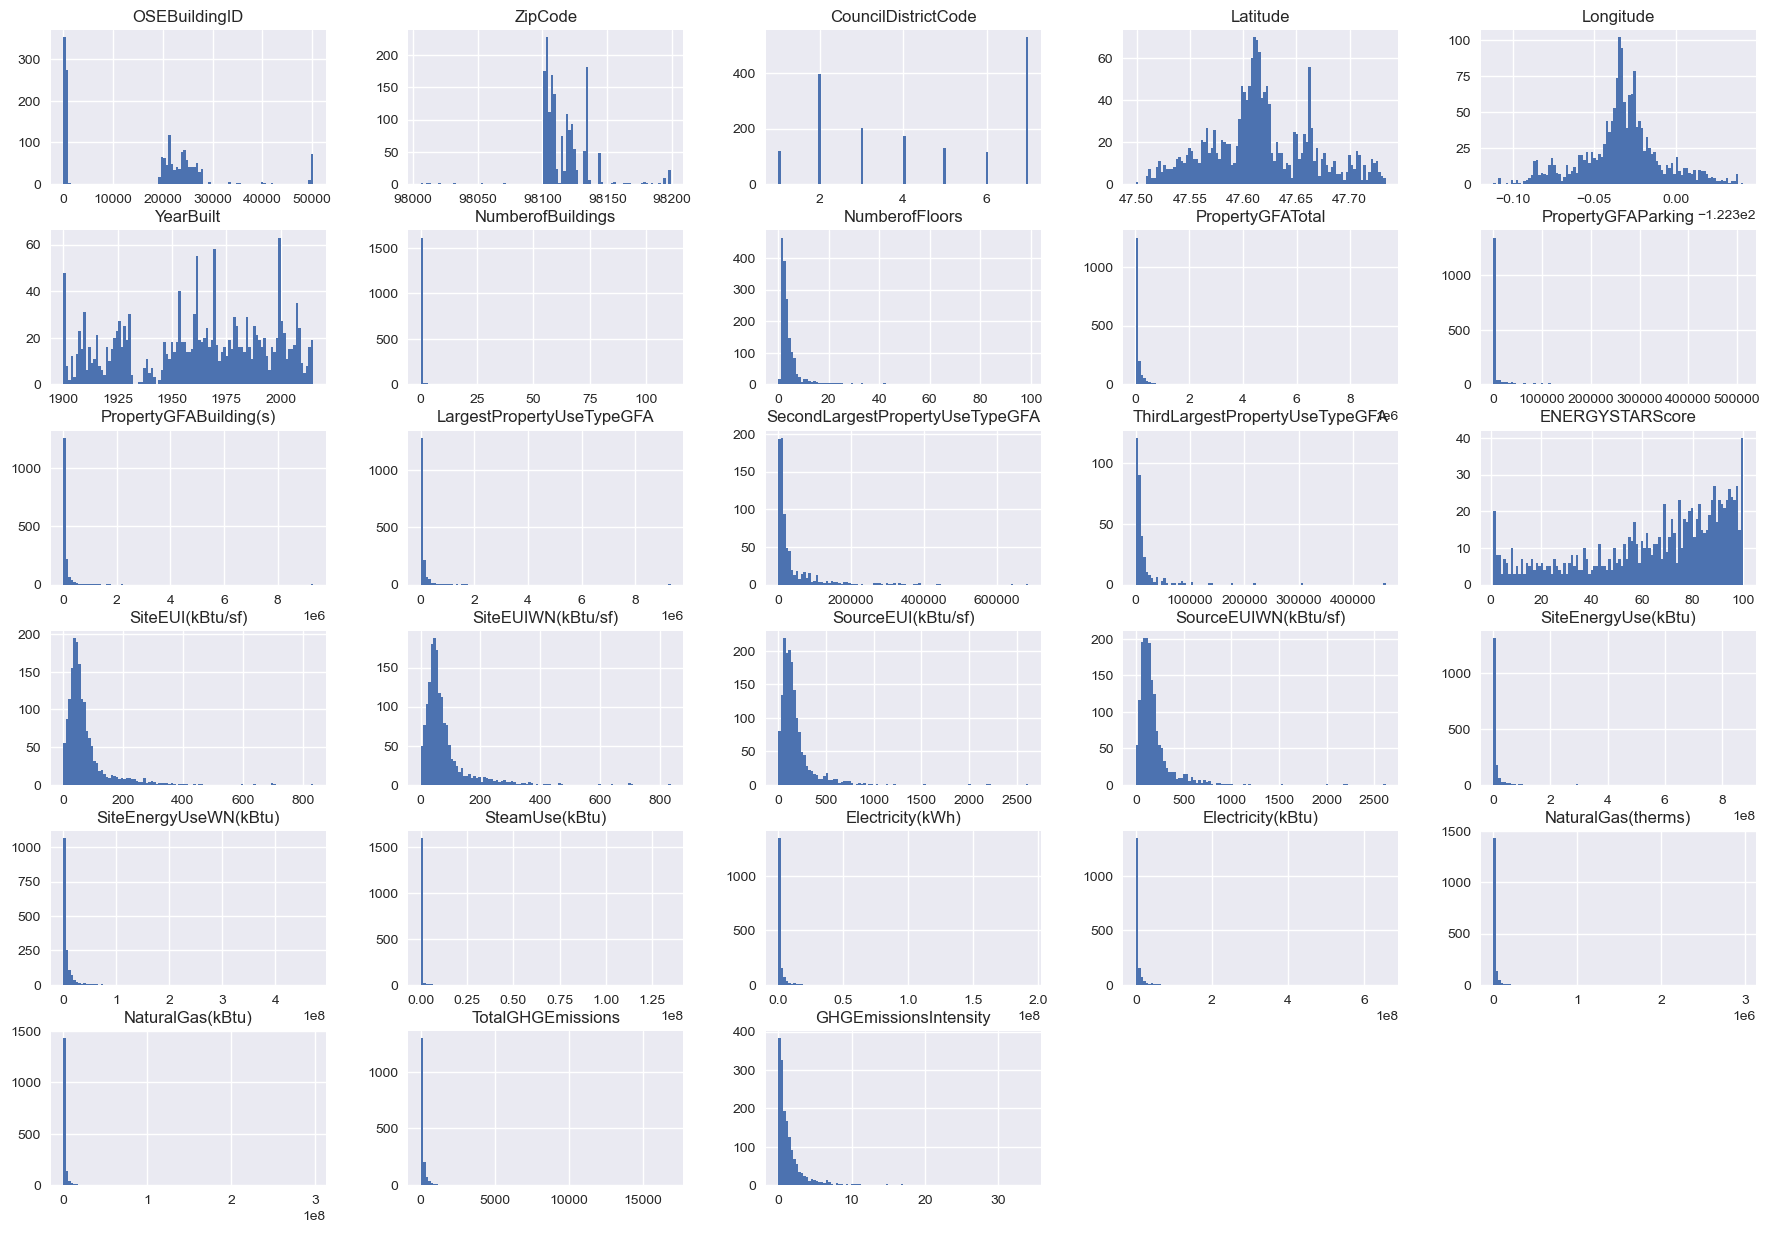

In [186]:
plt.style.use('seaborn')
df1.hist(bins=100, figsize=(22,15))
plt.show()

<AxesSubplot:>

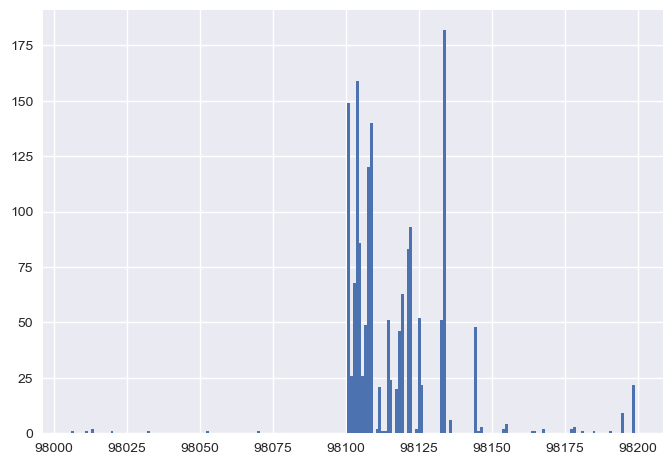

In [187]:
df1['ZipCode'].hist(bins=200)

In [188]:
df1['ZipCode'].value_counts().sort_index()

98006.0      1
98011.0      1
98013.0      2
98020.0      1
98033.0      1
98053.0      1
98070.0      1
98101.0    149
98102.0     26
98103.0     68
98104.0    159
98105.0     86
98106.0     26
98107.0     49
98108.0    120
98109.0    140
98111.0      2
98112.0     21
98113.0      1
98114.0      1
98115.0     51
98116.0     24
98117.0     20
98118.0     46
98119.0     63
98121.0     83
98122.0     93
98124.0      2
98125.0     52
98126.0     22
98133.0     51
98134.0    182
98136.0      6
98144.0     48
98145.0      1
98146.0      3
98154.0      2
98155.0      4
98164.0      1
98165.0      1
98168.0      2
98177.0      2
98178.0      3
98181.0      1
98185.0      1
98191.0      1
98195.0      9
98199.0     22
Name: ZipCode, dtype: int64

## Matrice de corrélation (heatmap)

In [189]:
df_corr = df1.corr()
print("Matrice de corrélation :")
display(df_corr)

Matrice de corrélation :


OSEBuildingID   ZipCode  CouncilDistrictCode  \
OSEBuildingID                         1.000000  0.136823            -0.163692   
ZipCode                               0.136823  1.000000            -0.191513   
CouncilDistrictCode                  -0.163692 -0.191513             1.000000   
Latitude                              0.032358  0.000221             0.527574   
Longitude                             0.093759 -0.014638            -0.332862   
YearBuilt                            -0.003484  0.096800            -0.048781   
NumberofBuildings                     0.046140 -0.014958            -0.017283   
NumberofFloors                       -0.252541 -0.144742             0.277981   
PropertyGFATotal                     -0.149523 -0.059472             0.108981   
PropertyGFAParking                   -0.217268 -0.096514             0.193338   
PropertyGFABuilding(s)               -0.124125 -0.047862             0.085266   
LargestPropertyUseTypeGFA            -0.112434 -0.041160             0.069023   
SecondLargestPropertyUseTypeGFA      -0.232428 -0.053851             0.162041   
ThirdLargestPropertyUseTypeGFA       -0.159483 -0.011168             0.015616   
ENERGYSTARScore                      -0.047328 -0.000939             0.097383   
SiteEUI(kBtu/sf)                     -0.008460 -0.064709             0.079622   
SiteEUIWN(kBtu/sf)                   -0.004273 -0.069510             0.075309   
SourceEUI(kBtu/sf)                   -0.048181 -0.057446             0.106880   
SourceEUIWN(kBtu/sf)                 -0.047627 -0.062297             0.106583   
SiteEnergyUse(kBtu)                  -0.089423 -0.048971             0.048816   
SiteEnergyUseWN(kBtu)                -0.186088 -0.056616             0.069789   
SteamUse(kBtu)                       -0.011553 -0.049473             0.008007   
Electricity(kWh)                     -0.100153 -0.047294             0.074257   
Electricity(kBtu)                    -0.100153 -0.047294             0.074257   
NaturalGas(therms)                   -0.073453 -0.024403            -0.009757   
NaturalGas(kBtu)                     -0.073453 -0.024403            -0.009757   
TotalGHGEmissions                    -0.074462 -0.053274             0.012391   
GHGEmissionsIntensity                 0.084478 -0.069757            -0.003264   

                                 Latitude  Longitude  YearBuilt  \
OSEBuildingID                    0.032358   0.093759  -0.003484   
ZipCode                          0.000221  -0.014638   0.096800   
CouncilDistrictCode              0.527574  -0.332862  -0.048781   
Latitude                         1.000000  -0.092595   0.066119   
Longitude                       -0.092595   1.000000   0.016216   
YearBuilt                        0.066119   0.016216   1.000000   
NumberofBuildings                0.020543   0.020779  -0.030527   
NumberofFloors                  -0.009711  -0.013360   0.094417   
PropertyGFATotal                 0.006030   0.021227   0.102894   
PropertyGFAParking               0.038992  -0.027642   0.277118   
PropertyGFABuilding(s)           0.000509   0.026321   0.066436   
LargestPropertyUseTypeGFA        0.006409   0.029736   0.069556   
SecondLargestPropertyUseTypeGFA  0.002154   0.024763   0.275610   
ThirdLargestPropertyUseTypeGFA  -0.128951   0.040063   0.166575   
ENERGYSTARScore                  0.040510   0.002200  -0.033748   
SiteEUI(kBtu/sf)                 0.089395  -0.020419   0.126278   
SiteEUIWN(kBtu/sf)               0.088095  -0.020655   0.120614   
SourceEUI(kBtu/sf)               0.087223  -0.023033   0.161315   
SourceEUIWN(kBtu/sf)             0.087099  -0.023280   0.159221   
SiteEnergyUse(kBtu)              0.010457   0.033090   0.064116   
SiteEnergyUseWN(kBtu)           -0.007422   0.024697   0.133071   
SteamUse(kBtu)                  -0.004994   0.021025  -0.004016   
Electricity(kWh)                 0.011338   0.022949   0.073984   
Electricity(kBtu)                0.011338   0.022949   0.073984   
NaturalG

##### Représentation sous forme de heatmap

<AxesSubplot:>

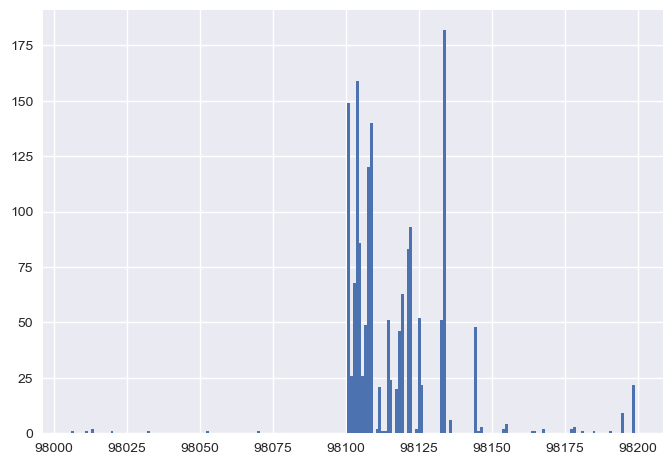

In [190]:
df1['ZipCode'].hist(bins=200)

In [191]:
df1['ZipCode'].value_counts().sort_index()

98006.0      1
98011.0      1
98013.0      2
98020.0      1
98033.0      1
98053.0      1
98070.0      1
98101.0    149
98102.0     26
98103.0     68
98104.0    159
98105.0     86
98106.0     26
98107.0     49
98108.0    120
98109.0    140
98111.0      2
98112.0     21
98113.0      1
98114.0      1
98115.0     51
98116.0     24
98117.0     20
98118.0     46
98119.0     63
98121.0     83
98122.0     93
98124.0      2
98125.0     52
98126.0     22
98133.0     51
98134.0    182
98136.0      6
98144.0     48
98145.0      1
98146.0      3
98154.0      2
98155.0      4
98164.0      1
98165.0      1
98168.0      2
98177.0      2
98178.0      3
98181.0      1
98185.0      1
98191.0      1
98195.0      9
98199.0     22
Name: ZipCode, dtype: int64

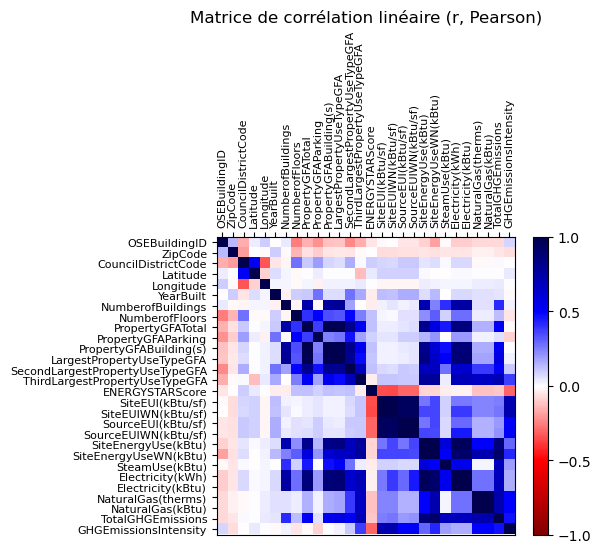

In [192]:
plt.style.use('default')
plt.matshow(df_corr, cmap='seismic_r', vmin=-1, vmax=1)
ticks = range(len(df_corr.columns))
plt.xticks(ticks,
           fontsize=8,
           labels=df_corr.columns,
           rotation=90)
plt.yticks(ticks, fontsize=8, labels=df_corr.columns)
plt.tick_params(bottom=False)
plt.colorbar(shrink=0.8, ticks=[-1, -0.5, 0, 0.5, 1])
plt.title('Matrice de corrélation linéaire (r, Pearson)')
plt.show()

##### Affichage des corrélations les plus fortes

In [193]:
df_corr_2 = pd.DataFrame(columns=['corrélation', 'var1', 'var2'])    # dataframe à 3 colonnes : 'corrélation', 'var1', 'var2'
for i in range(df_corr.shape[0]):
    for j in range(i):
        df_corr_2 = df_corr_2.append({'corrélation': df_corr.iloc[i,j], 'var1': df_corr.columns[i], 'var2': df_corr.columns[j]}, ignore_index=True)
df_corr_2 = df_corr_2.sort_values('corrélation', ascending=False, inplace=False)
df_corr_2 = df_corr_2.reset_index(drop=True)

In [194]:
df_corr_2.head(50)

corrélation                             var1  \
0      1.000000                Electricity(kBtu)   
1      1.000000                 NaturalGas(kBtu)   
2      0.999427            SiteEnergyUseWN(kBtu)   
3      0.999251             SourceEUIWN(kBtu/sf)   
4      0.998815               SiteEUIWN(kBtu/sf)   
5      0.990450           PropertyGFABuilding(s)   
6      0.982238        LargestPropertyUseTypeGFA   
7      0.977648        LargestPropertyUseTypeGFA   
8      0.956248                 Electricity(kWh)   
9      0.956248                Electricity(kBtu)   
10     0.951637             SourceEUIWN(kBtu/sf)   
11     0.950174               SourceEUI(kBtu/sf)   
12     0.945132             SourceEUIWN(kBtu/sf)   
13     0.941980               SourceEUI(kBtu/sf)   
14     0.920815                TotalGHGEmissions   
15     0.908064                 Electricity(kWh)   
16     0.908064                Electricity(kBtu)   
17     0.884147                 Electricity(kWh)   
18     0.884147                Electricity(kBtu)   
19     0.871797                Electricity(kBtu)   
20     0.871797                 Electricity(kWh)   
21     0.861831                Electricity(kBtu)   
22     0.861831                 Electricity(kWh)   
23     0.859966                TotalGHGEmissions   
24     0.845951              SiteEnergyUse(kBtu)   
25     0.825695              SiteEnergyUse(kBtu)   
26     0.825036  SecondLargestPropertyUseTypeGFA   
27     0.809479              SiteEnergyUse(kBtu)   
28     0.808899  SecondLargestPropertyUseTypeGFA   
29     0.799783  SecondLargestPropertyUseTypeGFA   
30     0.796707        LargestPropertyUseTypeGFA   
31     0.775542            SiteEnergyUseWN(kBtu)   
32     0.775499              SiteEnergyUse(kBtu)   
33     0.770237           PropertyGFABuilding(s)   
34     0.757527                Electricity(kBtu)   
35     0.757527                 Electricity(kWh)   
36     0.734529                 PropertyGFATotal   
37     0.726096            GHGEmissionsIntensity   
38     0.725999                TotalGHGEmissions   
39     0.725999                TotalGHGEmissions   
40     0.723515               NaturalGas(therms)   
41     0.723515                 NaturalGas(kBtu)   
42     0.713102              SiteEnergyUse(kBtu)   
43     0.711020            GHGEmissionsIntensity   
44     0.704578                TotalGHGEmissions   
45     0.694732                Electricity(kBtu)   
46     0.694732                 Electricity(kWh)   
47     0.686572                TotalGHGEmissions   
48     0.686572                TotalGHGEmissions   
49     0.684001                TotalGHGEmissions   

                              var2  
0                 Electricity(kWh)  
1               NaturalGas(therms)  
2              SiteEnergyUse(kBtu)  
3               SourceEUI(kBtu/sf)  
4                 SiteEUI(kBtu/sf)  
5                 PropertyGFATotal  
6           PropertyGFABuilding(s)  
7                 PropertyGFATotal  
8              SiteEnergyUse(kBtu)  
9              SiteEnergyUse(kBtu)  
10                SiteEUI(kBtu/sf)  
11                SiteEUI(kBtu/sf)  
12              SiteEUIWN(kBtu/sf)  
13              SiteEUIWN(kBtu/sf)  
14           SiteEnergyUseWN(kBtu)  
15           SiteEnergyUseWN(kBtu)  
16           SiteEnergyUseWN(kBtu)  
17       LargestPropertyUseTypeGFA  
18       LargestPropertyUseTypeGFA  
19          PropertyGFABuilding(s)  
20          PropertyGFABuilding(s)  
21                PropertyGFATotal  
22                PropertyGFATotal  
23             SiteEnergyUse(kBtu)  
24       LargestPropertyUseTypeGFA  
25          PropertyGFABuilding(s)  
26                PropertyGFATotal  
27                PropertyGFATotal  
28          PropertyGFABuilding(s)  
29       LargestPropertyUseTypeGFA  
30               NumberofBuildings  
31  ThirdLargestPropertyUseTypeGFA  
32  ThirdLargestPropertyUseTypeGFA  
33               NumberofBuildings  
34               NumberofBuildings  
35               Nu

In [195]:
df_corr_2.tail(10)

corrélation                             var1                 var2
368    -0.191513              CouncilDistrictCode              ZipCode
369    -0.217268               PropertyGFAParking        OSEBuildingID
370    -0.232428  SecondLargestPropertyUseTypeGFA        OSEBuildingID
371    -0.252541                   NumberofFloors        OSEBuildingID
372    -0.297997            GHGEmissionsIntensity      ENERGYSTARScore
373    -0.298536               SourceEUI(kBtu/sf)      ENERGYSTARScore
374    -0.299792             SourceEUIWN(kBtu/sf)      ENERGYSTARScore
375    -0.332862                        Longitude  CouncilDistrictCode
376    -0.349977                 SiteEUI(kBtu/sf)      ENERGYSTARScore
377    -0.354204               SiteEUIWN(kBtu/sf)      ENERGYSTARScore

On met à jour la liste des variables quantitatives en supprimant les variables fortement corrélées (r>0.99) :  

In [196]:
set_var_quanti_conservees = set(df_corr.columns) - {'NaturalGas(therms)', 'Electricity(kWh)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'PropertyGFATotal'}

La liste des variables qualitatives est la suivante :

In [197]:
set_var_quali = set(df1.columns) - set(df_corr.columns)
set_var_quali

{'BuildingType',
 'LargestPropertyUseType',
 'Neighborhood',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'}

## PCA

On analyse ici les corrélations entre les variables suivantes :  

In [198]:
print("Nb de variables :", len(set_var_quanti_conservees))
set_var_quanti_conservees

Nb de variables : 22


{'CouncilDistrictCode',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'Latitude',
 'Longitude',
 'NaturalGas(kBtu)',
 'NumberofBuildings',
 'NumberofFloors',
 'OSEBuildingID',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SteamUse(kBtu)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'YearBuilt',
 'ZipCode'}

##### Eboulis des valeurs propres

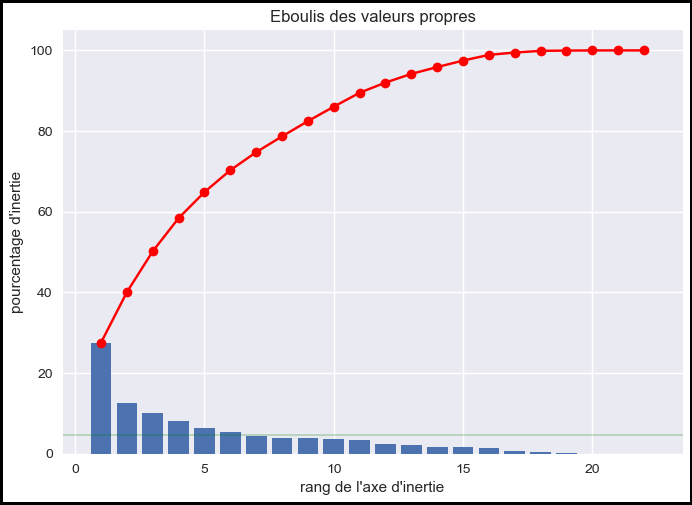

In [199]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = df1[set_var_quanti_conservees]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean(
))  # remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=22)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

Interprétation de l'éboulis : 
- les variables sont modérément corrélées entre elles.
- en se basant sur le critère de Kaiser, matérialisé par le trait bleu horizontal (%inertie > 100/28), on ne représentera les cercles des corrélations que pour les 6 premières composantes (F1 à F6).

##### Cercles des corrélations

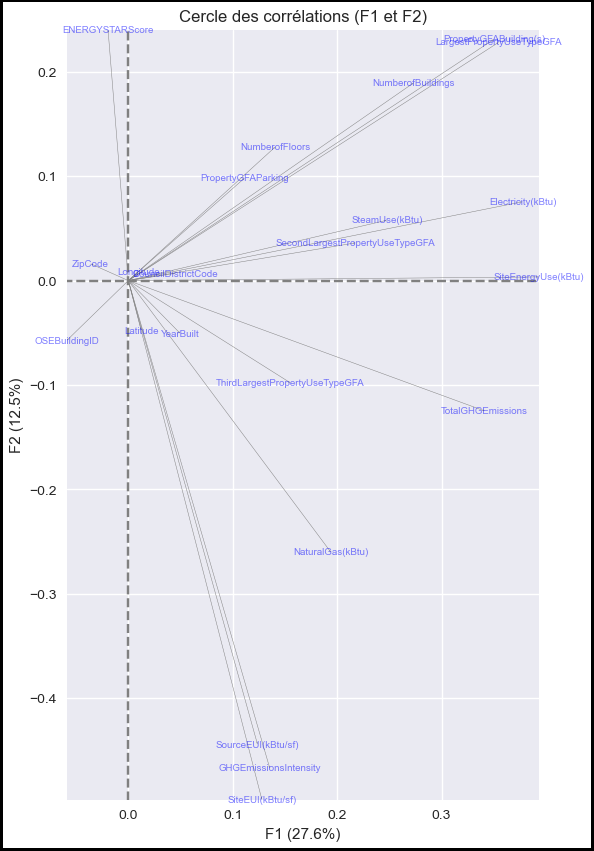

In [200]:
# Cercle des corrélations : premier plan factoriel
pcs = pca.components_
display_circles(pca, [(0,1)], labels = np.array(features), lims='auto')

Interprétation du premier plan factoriel (F1 et F2) :  
- les variables les plus corrélées à F1 sont les variables corrélées à la quantité d'énergie consommée par bâtiment.
- les variables les plus corrélées à F2 sont les variables (anti)corrélées à la quantité d'énergie consommée par unité de surface.

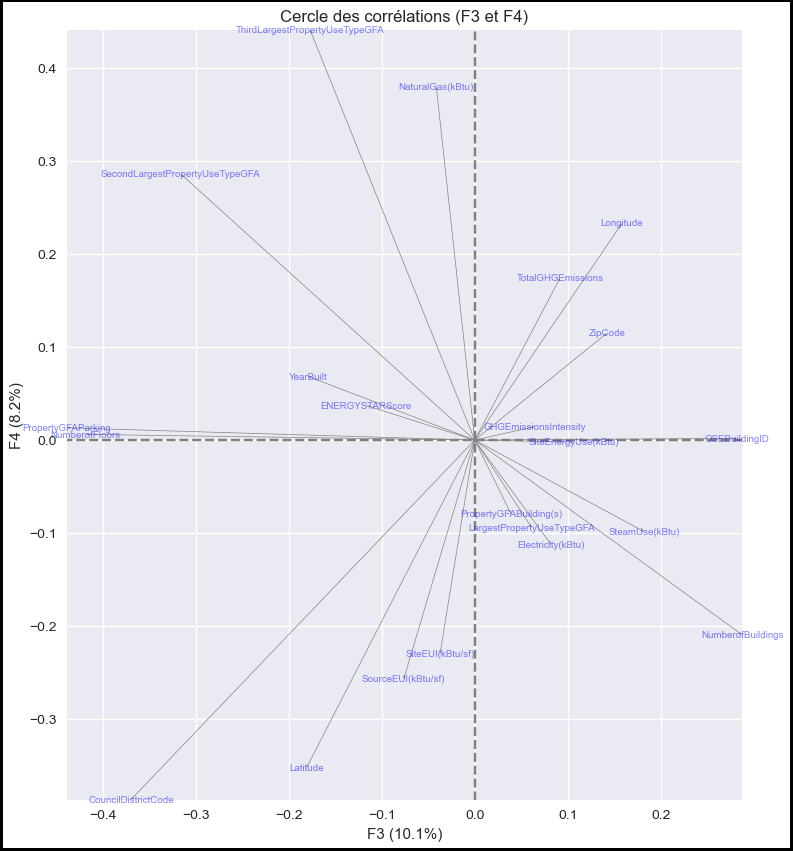

In [201]:
# Cercle des corrélations : second plan factoriel
display_circles(pca, [(2,3)], labels = np.array(features), lims='auto')

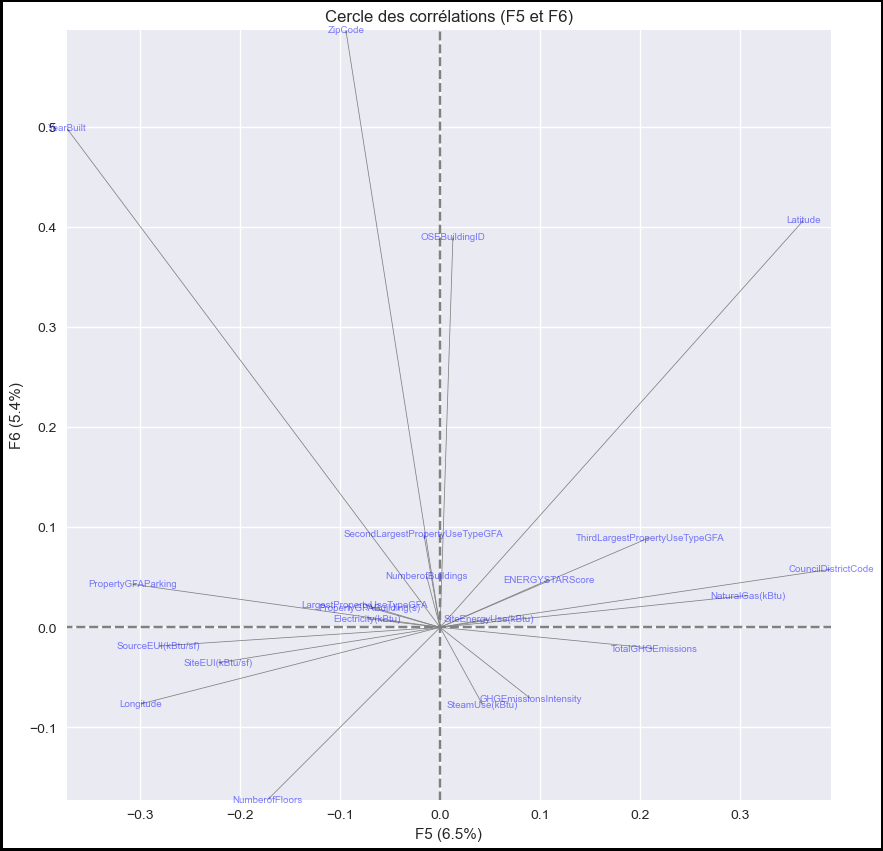

In [202]:
# Cercle des corrélations : 3è plan factoriel
display_circles(pca, [(4,5)], labels = np.array(features), lims='auto')

Interprétation du second plan factoriel (F3 et F4) et du troisième plan (F5 et F6) :  
- je ne vois pas comment on peut "interpréter" la signification de F3, F4, F5, F6.

## Scatter plots

### Fonction scatter_plot()

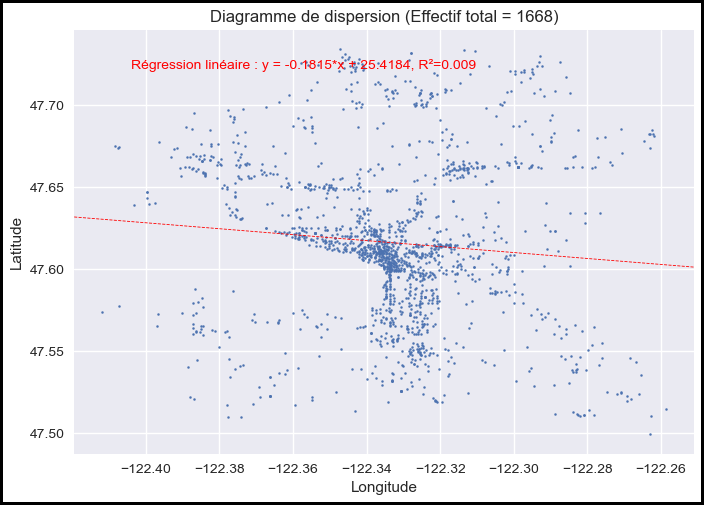

In [203]:
# test de scatter_plot()
scatter_plot(ser_x=df1['Longitude'], ser_y=df1['Latitude'])

### Variables avec r>0.99

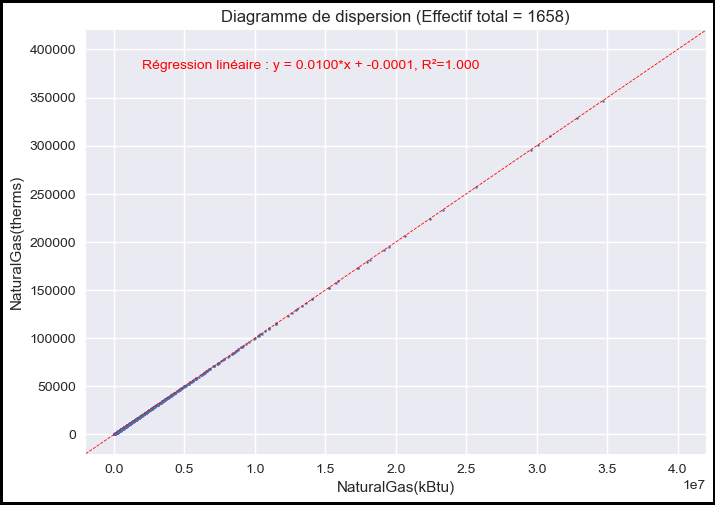

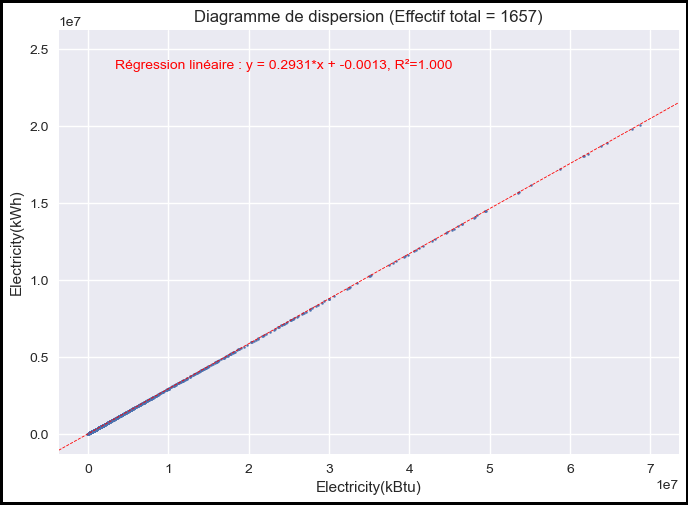

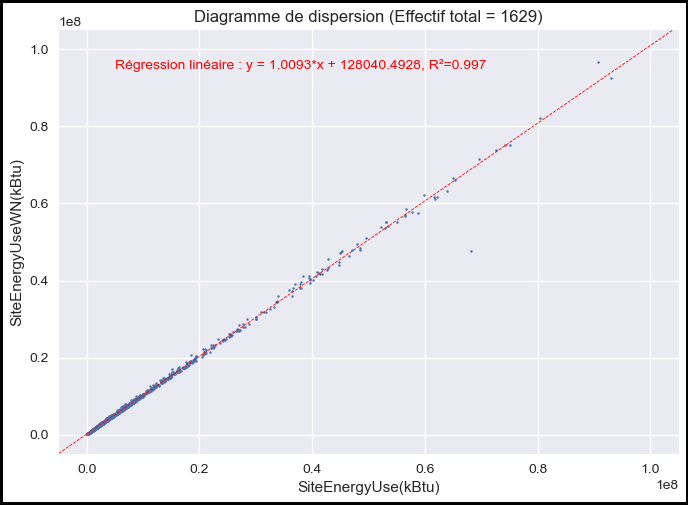

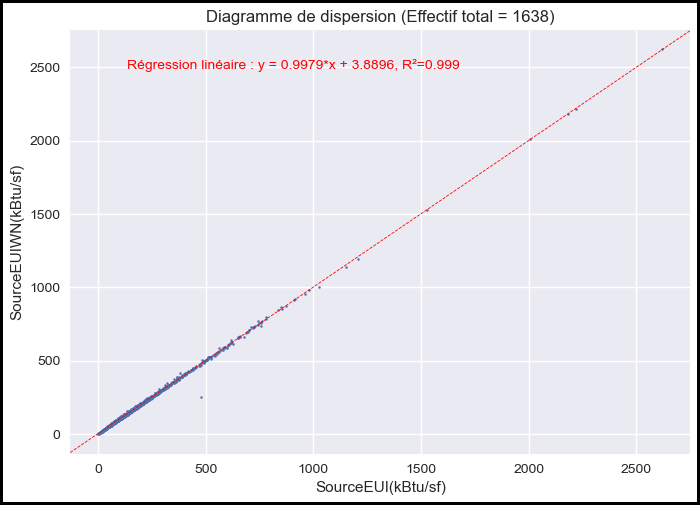

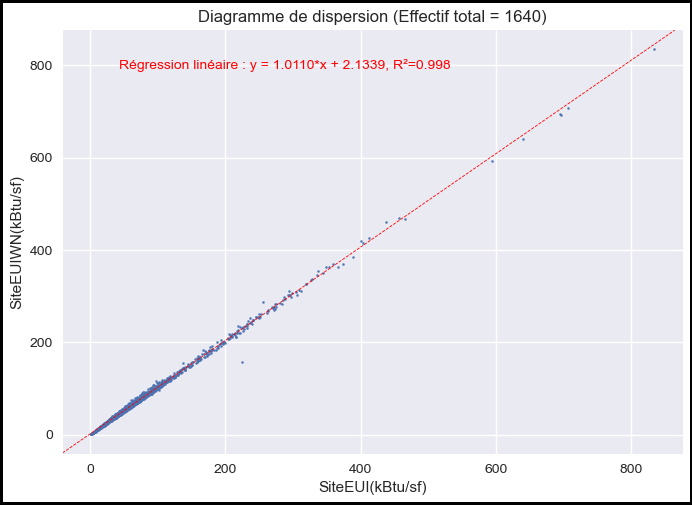

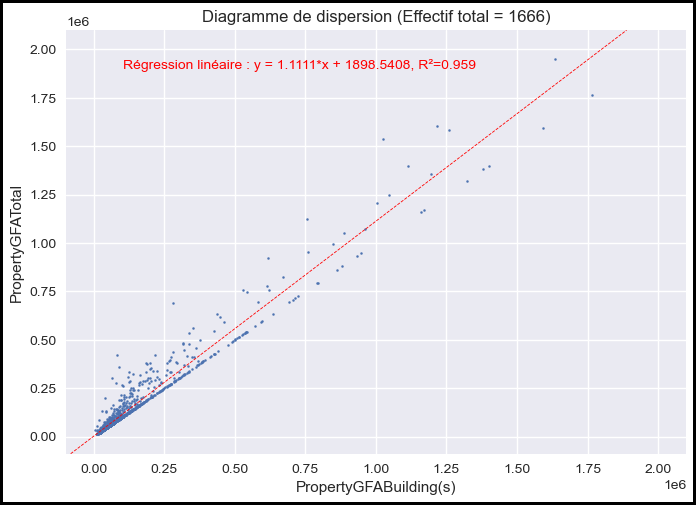

In [204]:
scatter_plot(ser_x=df1['NaturalGas(kBtu)'], ser_y=df1['NaturalGas(therms)'], max_x=4e7, max_y=4e5)
scatter_plot(ser_x=df1['Electricity(kBtu)'], ser_y=df1['Electricity(kWh)'], max_x=7e7, max_y=2.5e7)
scatter_plot(ser_x=df1['SiteEnergyUse(kBtu)'], ser_y=df1['SiteEnergyUseWN(kBtu)'], max_x=1e8, max_y=1e8)
scatter_plot(ser_x=df1['SourceEUI(kBtu/sf)'], ser_y=df1['SourceEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)'], ser_y=df1['SiteEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df1['PropertyGFABuilding(s)'], ser_y=df1['PropertyGFATotal'], max_x=2e6, max_y=2e6)

## Vérifications de routine

### Somme des surfaces

#### 'PropertyGFATotal' = f('PropertyGFABuilding(s)' + 'PropertyGFAParking')

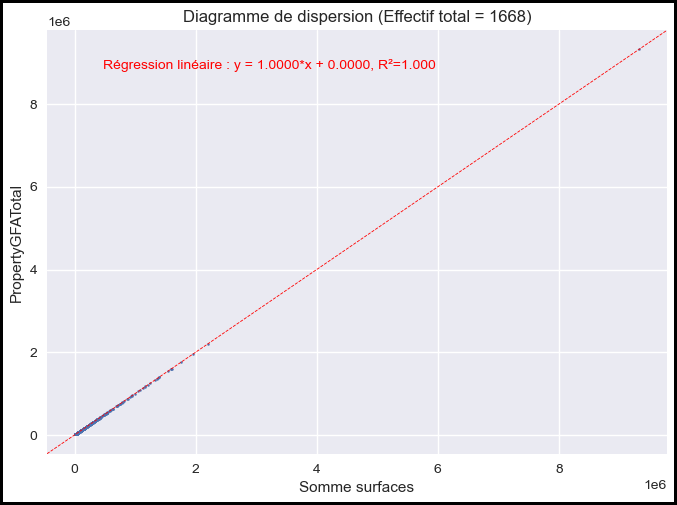

In [205]:
somme_surfaces = df1['PropertyGFABuilding(s)'] + df1['PropertyGFAParking']
somme_surfaces.name = 'Somme surfaces'
scatter_plot(ser_x=somme_surfaces, ser_y=df1['PropertyGFATotal'])

La somme des surfaces (variables 'PropertyGFABuilding(s)' et 'PropertyGFAParking') correspond parfaitement à PropertyGFATotal.

#### somme_types_surfaces = 'LargestPropertyUseTypeGFA' + 'SecondLargestPropertyUseTypeGFA' + 'ThirdLargestPropertyUseTypeGFA'

In [206]:
somme_types_surfaces = df1['LargestPropertyUseTypeGFA'].fillna(0) + df1['SecondLargestPropertyUseTypeGFA'].fillna(0) + df1['ThirdLargestPropertyUseTypeGFA'].fillna(0)
somme_types_surfaces.name = 'Somme surfaces : Largest+SecondLargest+ThirdLargest'

In [207]:
df1[['PrimaryPropertyType', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']].sample(10, random_state=0)

PrimaryPropertyType  PropertyGFABuilding(s)  PropertyGFAParking  \
2738  Small- and Mid-Sized Office                   26282               18228   
1839           Mixed Use Property                   43878                   0   
1139  Small- and Mid-Sized Office                   23307                8110   
1043                    Warehouse                   24000                   0   
2076                 Retail Store                   36071                   0   
921                  Retail Store                   32960                   0   
444   Small- and Mid-Sized Office                   94002                   0   
2411                        Other                   22200                   0   
1734                    Warehouse                   20200                   0   
568                  Retail Store                   77555                   0   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
2738                      Office                    26282.0   
1839         Multifamily Housing                    12000.0   
1139                      Office                    26295.0   
1043  Non-Refrigerated Warehouse                    20400.0   
2076                Retail Store                    36071.0   
921                 Retail Store                    32960.0   
444                       Office                    93905.0   
2411                       Other                    22200.0   
1734  Non-Refrigerated Warehouse                    18700.0   
568                 Retail Store                    73563.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
2738                      Parking                          18228.0   
1839                       Office                           8262.0   
1139                      Parking                          12890.0   
1043                       Office                           3600.0   
2076                          NaN                              NaN   
921                           NaN                              NaN   
444                       Parking                          31348.0   
2411                          NaN                              NaN   
1734                       Office                           1500.0   
568                           NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  
2738                         NaN                             NaN  
1839                Retail Store                          6312.0  
1139                         NaN                             NaN  
1043                         NaN                             NaN  
2076                         NaN                             NaN  
921                          NaN                             NaN  
444                          NaN                             NaN  
2411                         NaN                             NaN  
1734                         NaN                             NaN  
568                          NaN                             NaN

Exemples de data problématiques :  
- le bâtiment n°4 est un hotel. LargestPropertyUseType est l'hotel (surface supérieure au GFA Building). SecondLargestPropertyUseType est sa piscine.  
- le bâtiment n°444 : la superficie de parking est 0 (variable PropertyGFAParking) et 31348 (variable SecondLargestPropertyUseTypeGFA).

In [208]:
somme_types_surfaces.sample(10, random_state=0)

2738     44510.0
1839     26574.0
1139     39185.0
1043     24000.0
2076     36071.0
921      32960.0
444     125253.0
2411     22200.0
1734     20200.0
568      73563.0
Name: Somme surfaces : Largest+SecondLargest+ThirdLargest, dtype: float64

In [209]:
somme_types_surfaces.sort_values().head(10)

353         0.0
2670        0.0
2459        0.0
2414        0.0
1147        0.0
578         0.0
2019     8223.0
1568    10200.0
2833    11093.0
3363    11285.0
Name: Somme surfaces : Largest+SecondLargest+ThirdLargest, dtype: float64

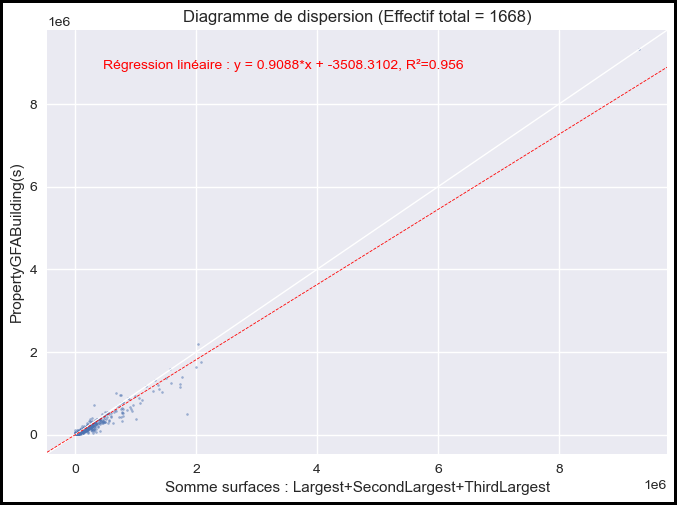

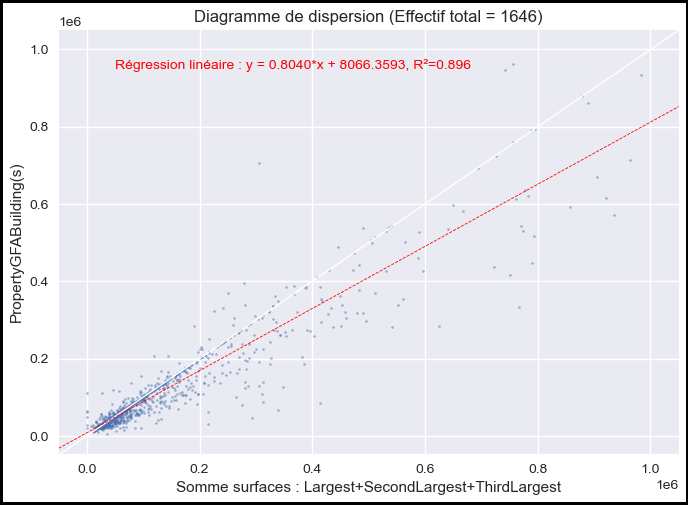

In [210]:
scatter_plot(ser_x=somme_types_surfaces, ser_y=df1['PropertyGFABuilding(s)'], alpha=0.5, ligne_diagonale=True)
scatter_plot(ser_x=somme_types_surfaces, ser_y=df1['PropertyGFABuilding(s)'], alpha=0.5, ligne_diagonale=True, max_x=1e6, max_y=1e6)

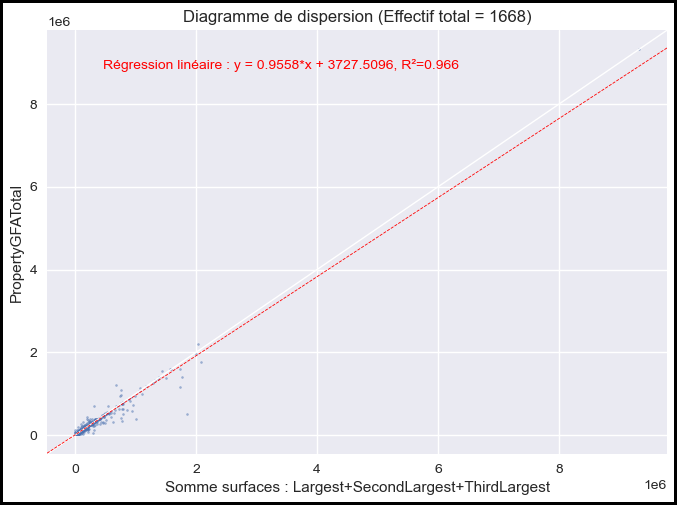

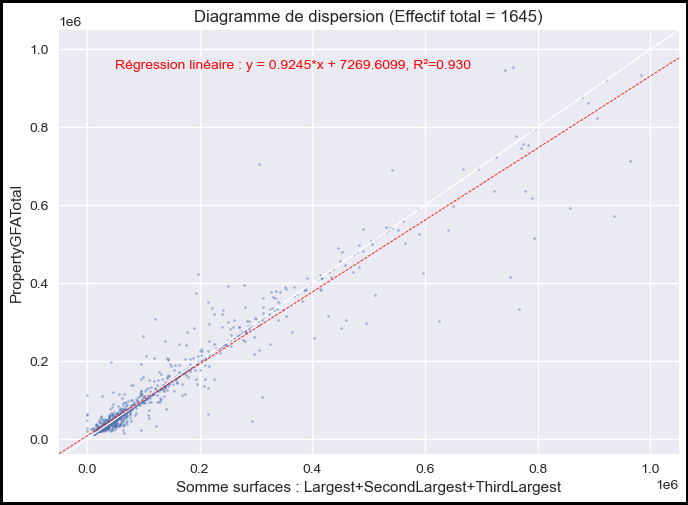

In [211]:
scatter_plot(ser_x=somme_types_surfaces, ser_y=df1['PropertyGFATotal'], alpha=0.5, ligne_diagonale=True)
scatter_plot(ser_x=somme_types_surfaces, ser_y=df1['PropertyGFATotal'], alpha=0.5, ligne_diagonale=True, max_x=1e6, max_y=1e6)

La variable somme_types_surfaces corrèle mieux avec 'PropertyGFATotal' (qui inclue les parkings) qu'avec 'PropertyGFABuilding(s)'.  
En analysant différentes lignes du tableau des surfaces des différents UseType, on voit que les données sont problématiques (les totaux recalculés par mes soins diffèrent des totaux fournis par les dataset).

### Somme des énergies consommées

##### 2015

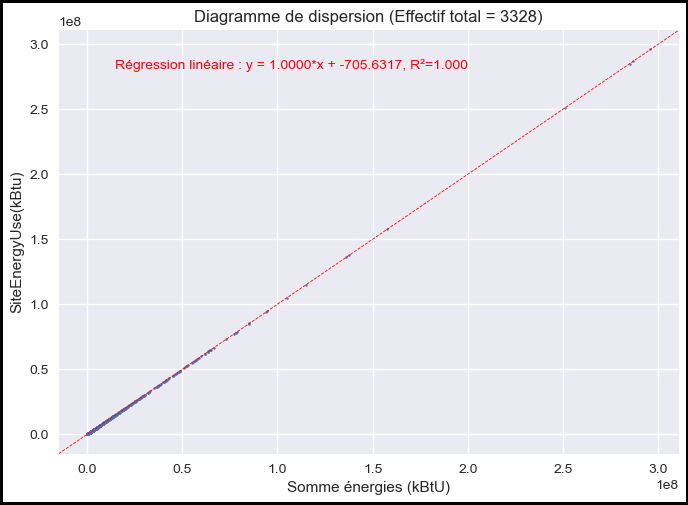

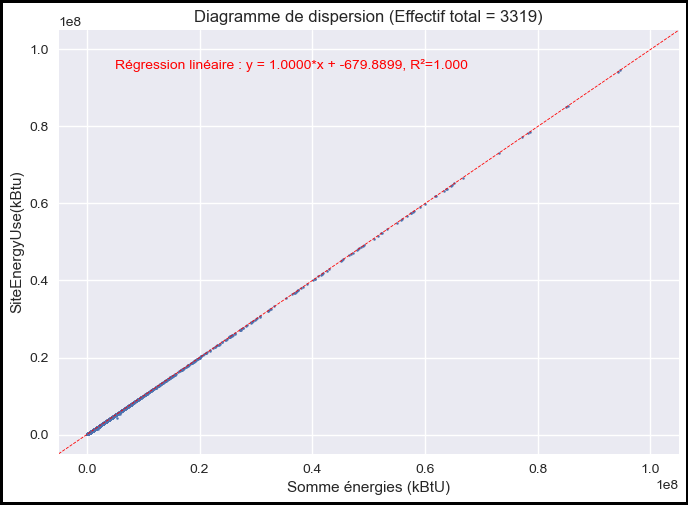

In [212]:
somme_energies_2015 = df2015['SteamUse(kBtu)'] + df2015['Electricity(kBtu)'] + df2015['NaturalGas(kBtu)'] + df2015['OtherFuelUse(kBtu)']
somme_energies_2015.name = 'Somme énergies (kBtU)'
scatter_plot(ser_x=somme_energies_2015, ser_y=df2015['SiteEnergyUse(kBtu)'])
scatter_plot(ser_x=somme_energies_2015, ser_y=df2015['SiteEnergyUse(kBtu)'], max_x=1e8, max_y=1e8)

Corrélation parfaite entre la somme des 4 variables de conso d'énergies (steam, electricity, natural gas, other fuel) et la variable SiteEnergyUse.

##### 2016

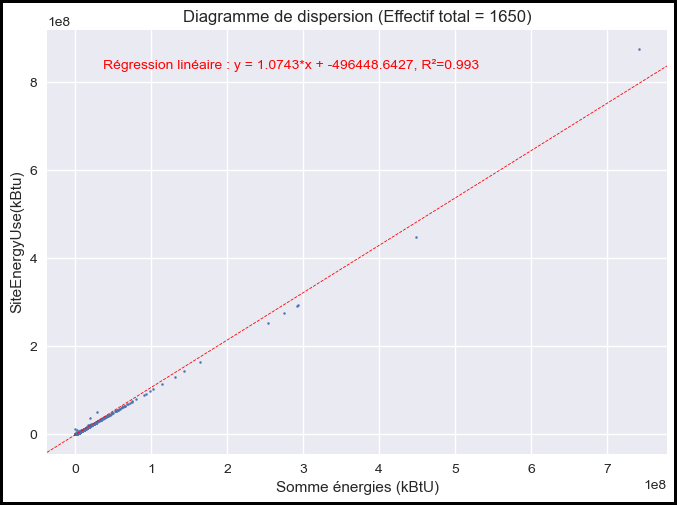

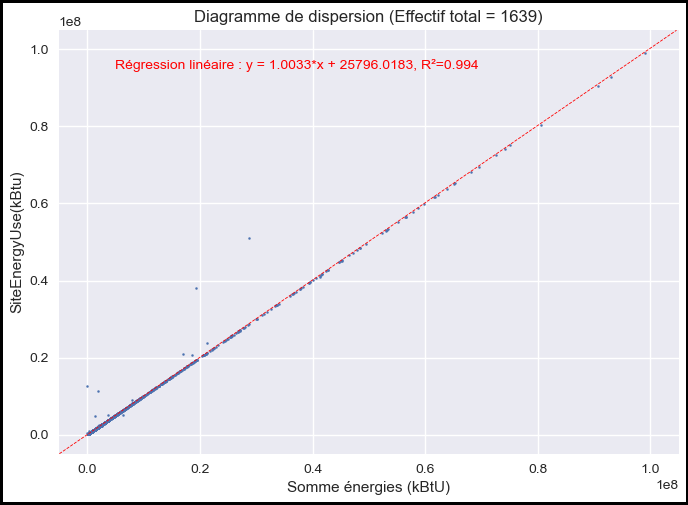

In [213]:
somme_energies_2016 = df1['SteamUse(kBtu)'] + df1['Electricity(kBtu)'] + df1['NaturalGas(kBtu)']
somme_energies_2016.name = 'Somme énergies (kBtU)'
scatter_plot(ser_x=somme_energies_2016, ser_y=df1['SiteEnergyUse(kBtu)'])
scatter_plot(ser_x=somme_energies_2016, ser_y=df1['SiteEnergyUse(kBtu)'], max_x=1e8, max_y=1e8)

Pour certains bâtiments il y a un écart significatif entre la somme des 3 variables de conso d'énergies (steam, electricity, natural gas) et la variable SiteEnergyUse. Dû à l'absence de la variable 'OtherFuelUse(kBtu)' dans le dataset de 2016.

### 'SiteEUI(kBtu/sf)' vs 'SourceEUI(kBtu/sf)'

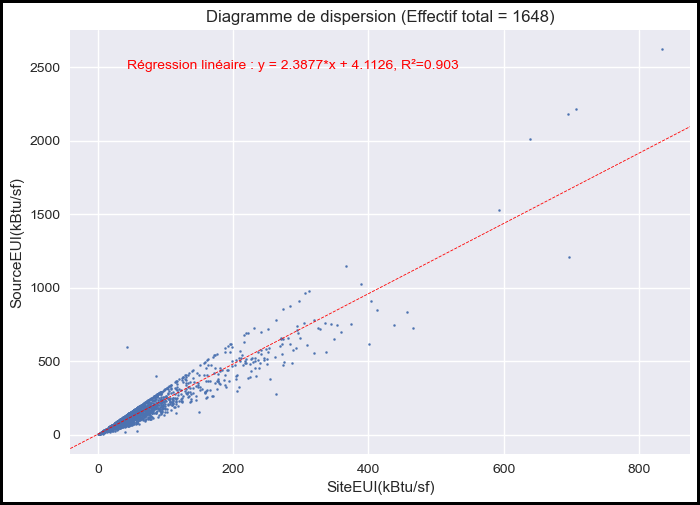

In [214]:
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)'], ser_y=df1['SourceEUI(kBtu/sf)'])

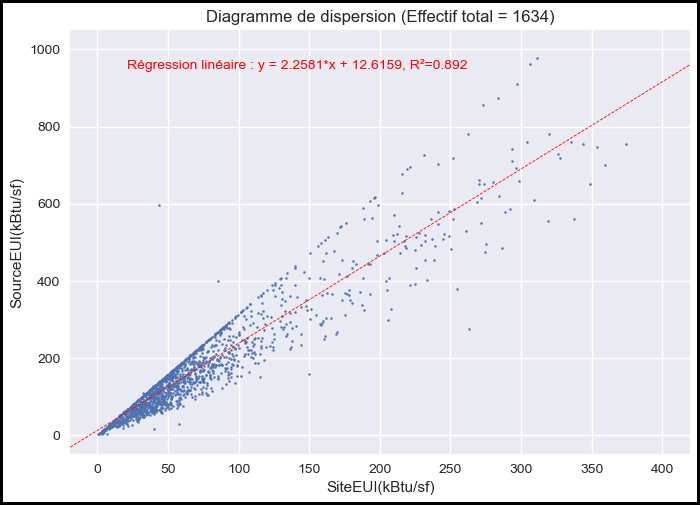

In [215]:
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)'], ser_y=df1['SourceEUI(kBtu/sf)'], max_x=400, max_y=1000)

### Consommations normalisé vs non normalisé

##### 2015 :

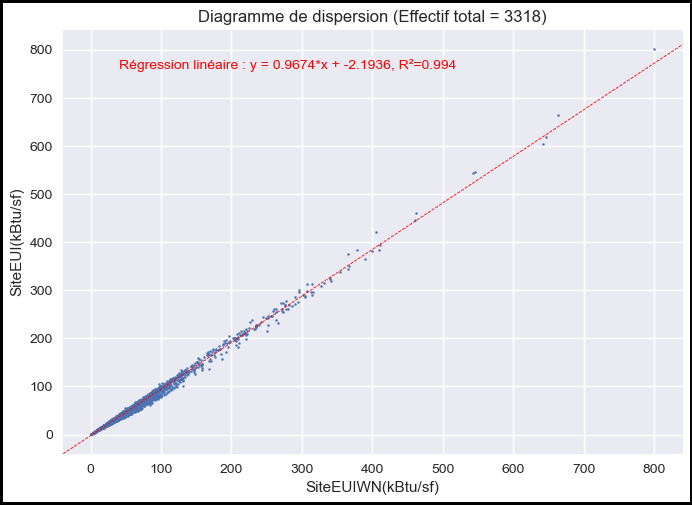

In [216]:
scatter_plot(ser_x=df2015['SiteEUIWN(kBtu/sf)'], ser_y=df2015['SiteEUI(kBtu/sf)'])

En 2015, la consommation d'énergie a été de 96.74% d'une année normalisée (WN).

##### 2016 :

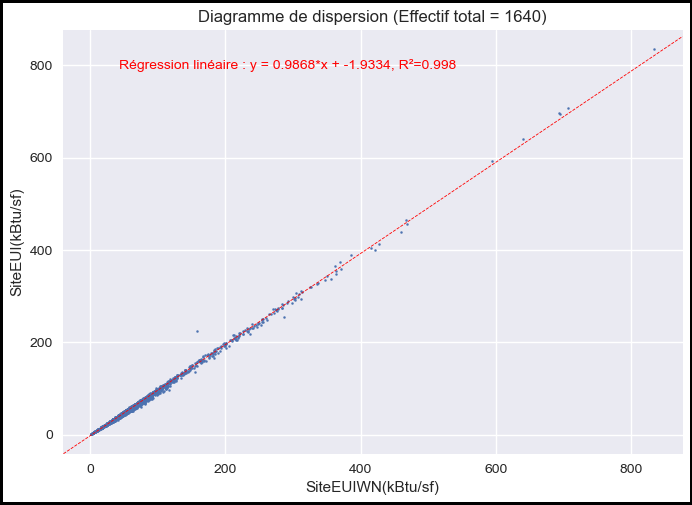

In [217]:
scatter_plot(ser_x=df1['SiteEUIWN(kBtu/sf)'], ser_y=df1['SiteEUI(kBtu/sf)'])

En 2016, la consommation d'énergie a été de 98.68% d'une année normalisée (WN).

### SiteEUIWN(kBtu/sf) 2015 vs 2016

In [218]:
df2015_conso = df2015[['OSEBuildingID', 'SiteEUIWN(kBtu/sf)']].copy()
df2015_conso.rename(columns = {'SiteEUIWN(kBtu/sf)' : 'SiteEUIWN(kBtu/sf)_2015'}, inplace = True)
df2016_conso = df1[['OSEBuildingID', 'SiteEUIWN(kBtu/sf)']].copy()
df2016_conso.rename(columns = {'SiteEUIWN(kBtu/sf)' : 'SiteEUIWN(kBtu/sf)_2016'}, inplace = True)
# Fusion sur la colonne OSEBuildingID
df_conso = pd.merge(df2015_conso, df2016_conso, on=['OSEBuildingID'])
df_conso

OSEBuildingID  SiteEUIWN(kBtu/sf)_2015  SiteEUIWN(kBtu/sf)_2016
0                 1                     80.3                84.300003
1                 2                     99.0                97.900002
2                 3                     99.7                97.699997
3                 5                    462.5               113.300003
4                 8                    122.1               118.699997
...             ...                      ...                      ...
1616          49966                     54.1                56.200001
1617          49985                     40.7                39.400002
1618          49998                      9.7                10.700000
1619          50002                     35.6                35.900002
1620          50038                     29.1                28.500000

[1621 rows x 3 columns]

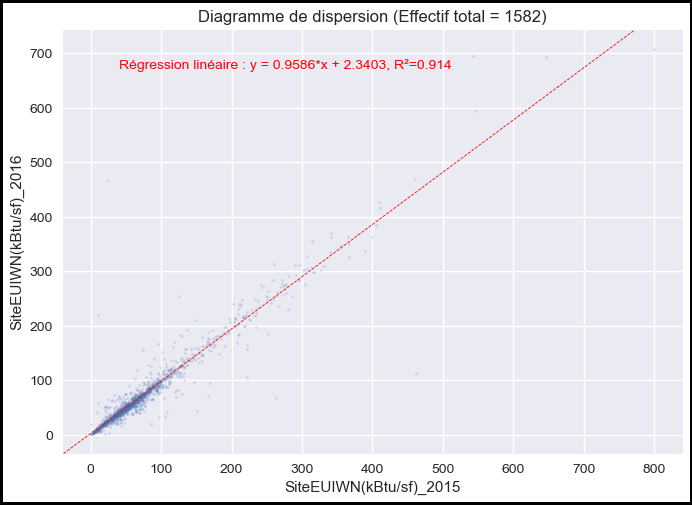

In [219]:
scatter_plot(ser_x=df_conso['SiteEUIWN(kBtu/sf)_2015'], ser_y=df_conso['SiteEUIWN(kBtu/sf)_2016'], alpha=0.2)

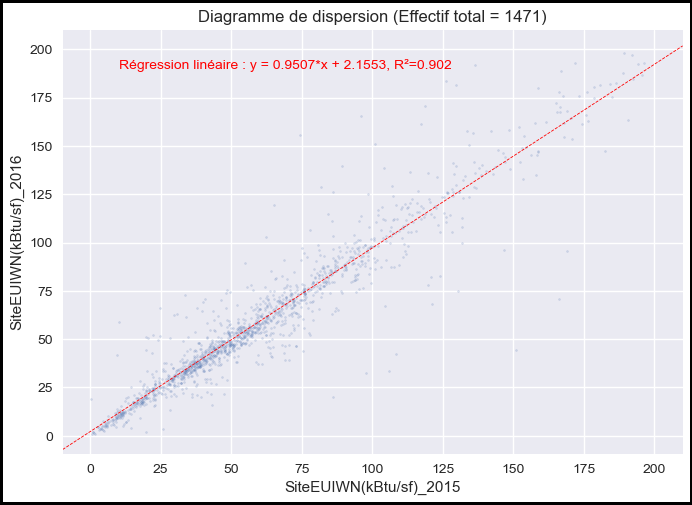

In [220]:
scatter_plot(ser_x=df_conso['SiteEUIWN(kBtu/sf)_2015'], ser_y=df_conso['SiteEUIWN(kBtu/sf)_2016'], alpha=0.2, max_x=200, max_y=200)

Ce graphique montre deux choses :  
    - les consommations normalisées baissent (pente < 1) entre 2015 et 2016 (meilleures isolations des bâtiments ?).  
    - bien qu'il y ait globalement une corrélation linéaire entre les données pour 2015 et 2016, la dispersion reste importante, et ON EVITERA D'UTILISER UN JEU DE DONNEES QUI MELANGE DES VALEURS DE 2015 ET 2016 pour la mise au point du modèle prédictif.

### GHGEmissionsIntensity = f('SiteEUIWN(kBtu/sf)')

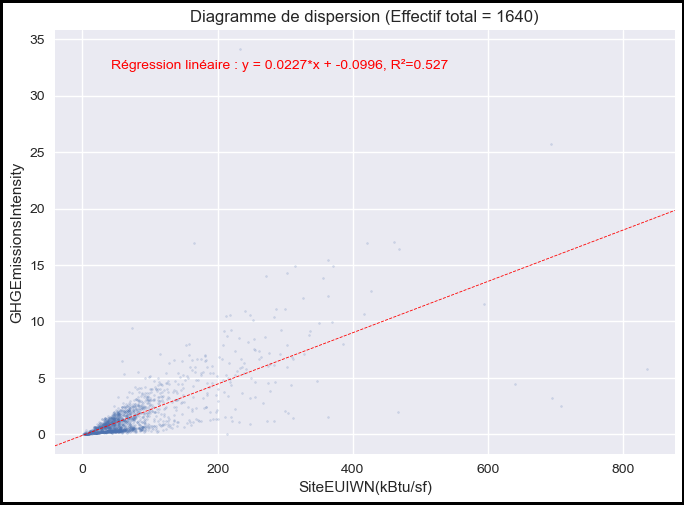

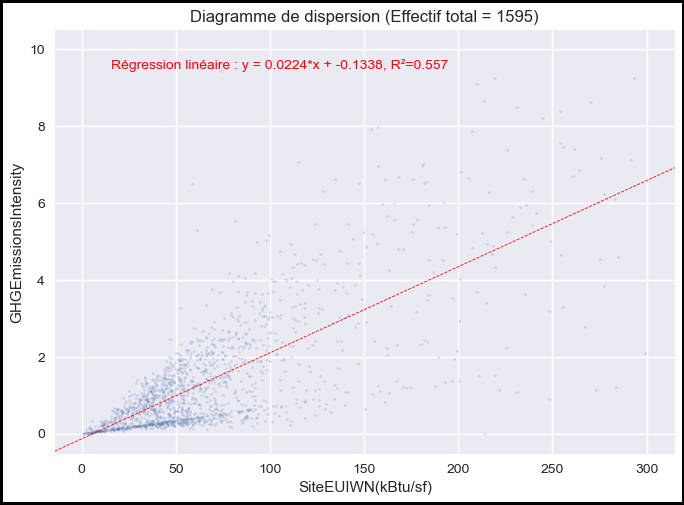

In [221]:
scatter_plot(ser_x=df1['SiteEUIWN(kBtu/sf)'], ser_y=df1['GHGEmissionsIntensity'], alpha=0.2, max_x=None, max_y=None)
scatter_plot(ser_x=df1['SiteEUIWN(kBtu/sf)'], ser_y=df1['GHGEmissionsIntensity'], alpha=0.2, max_x=300, max_y=10)

### 'SiteEnergyUse(kBtu)' = f('SiteEUI(kBtu/sf)'*Surface)

#### Surface = 'PropertyGFABuilding(s)'

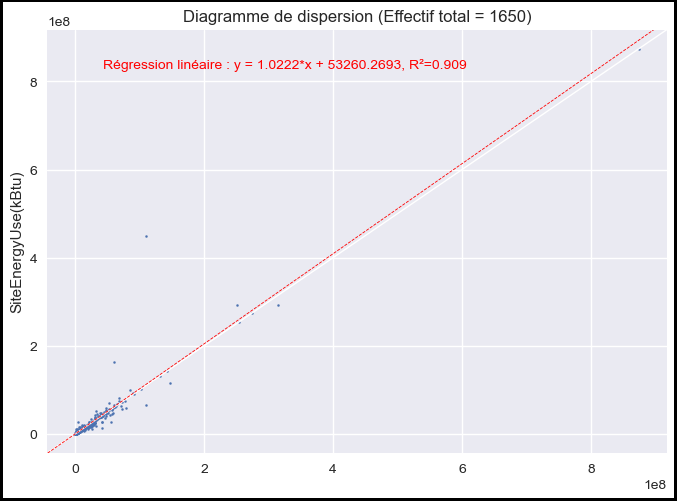

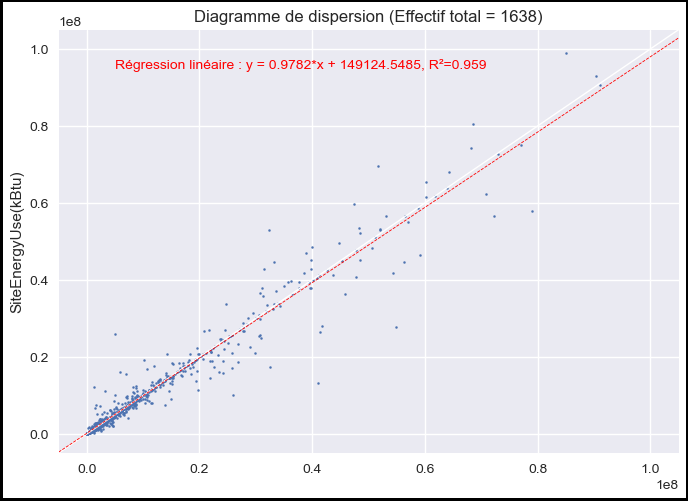

In [222]:
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*df1['PropertyGFABuilding(s)'], ser_y=df1['SiteEnergyUse(kBtu)'], alpha=1, max_x=None, max_y=None, ligne_diagonale=True)
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*df1['PropertyGFABuilding(s)'], ser_y=df1['SiteEnergyUse(kBtu)'], alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)

#### Surface = 'PropertyGFATotal'

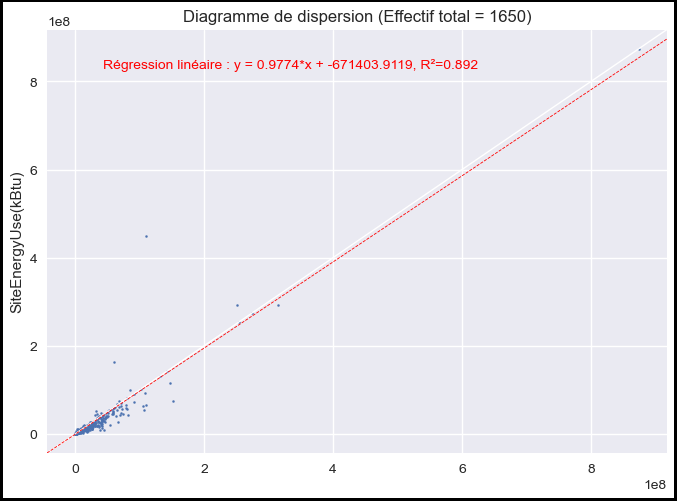

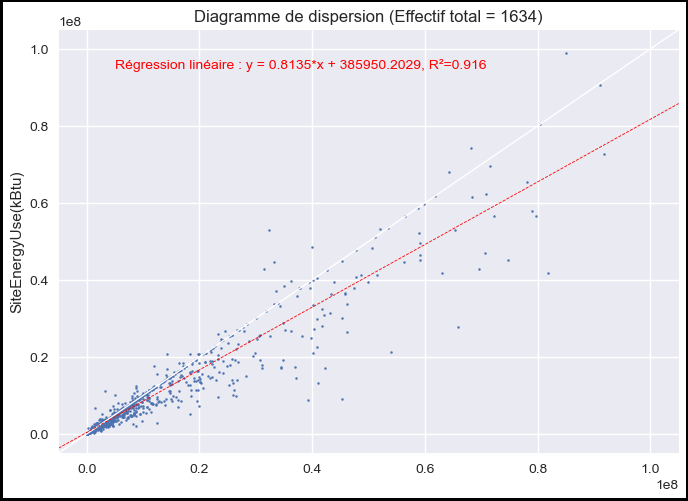

In [223]:
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*df1['PropertyGFATotal'], ser_y=df1['SiteEnergyUse(kBtu)'], alpha=1, max_x=None, max_y=None, ligne_diagonale=True)
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*df1['PropertyGFATotal'], ser_y=df1['SiteEnergyUse(kBtu)'], alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)

#### Surface = somme_types_surfaces

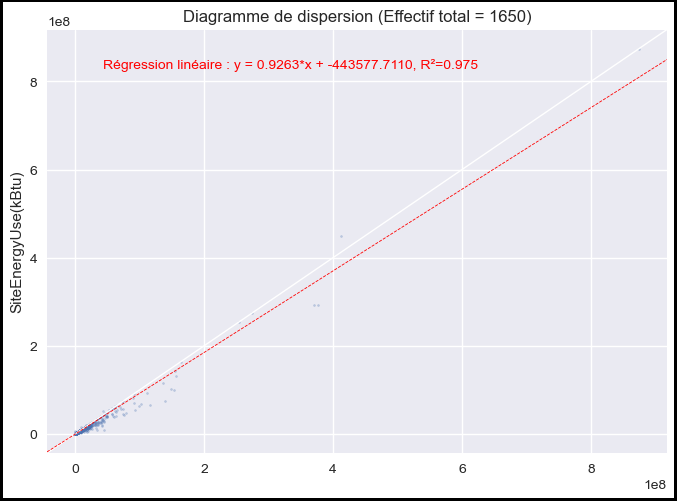

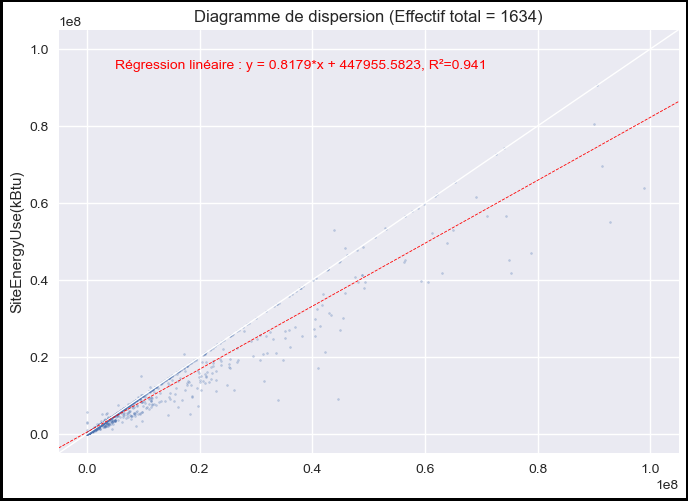

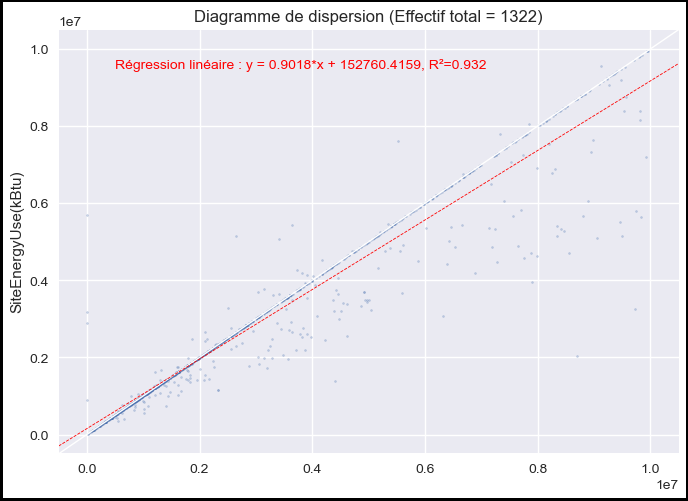

In [224]:
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*somme_types_surfaces, ser_y=df1['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=None, max_y=None, ligne_diagonale=True)
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*somme_types_surfaces, ser_y=df1['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=1e8, max_y=1e8, ligne_diagonale=True)
scatter_plot(ser_x=df1['SiteEUI(kBtu/sf)']*somme_types_surfaces, ser_y=df1['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=1e7, max_y=1e7, ligne_diagonale=True)

La meilleure corrélation entre la variable 'SiteEnergyUse(kBtu)' et la variable 'SiteEUI(kBtu/sf)'*Surface a été obtenue pour Surface = somme_types_surfaces (R²=0.98).

Il est plausible que la variable SiteEUI ait été calculée en divisant SiteEnergyUse par une variable de type Surface, hélas non renseignée dans le dataset. Les points bleus sur le scatter plot sont situés sous la droite y=x, ce qui veut dire que notre variable somme_types_surfaces minore la valeur réelle de cette surface.

### Somme des émissions de GHG

#### Création des variables ElectricityGHGEmissions, SteamUseGHGEmissions, NaturalGasGHGEmissions (exprimées en metric tons of CO2e equivalent)

In [225]:
df1['ElectricityGHGEmissions'] = 52.44/2204.6/1000 * df1['Electricity(kWh)'].copy()     # Electricity : 52.44 lbs CO2e/MWh    1MT=2204.6lbs

<ipython-input-225-d89231838bd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ElectricityGHGEmissions'] = 52.44/2204.6/1000 * df1['Electricity(kWh)'].copy()     # Electricity : 52.44 lbs CO2e/MWh    1MT=2204.6lbs


In [226]:
df1['SteamUseGHGEmissions'] = 170.17/2204.6/1000 * df1['SteamUse(kBtu)'].copy()    # 'SteamUse(kBtu)' : 170.17 lbs CO2e/MMBtu

<ipython-input-226-20a04f032262>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SteamUseGHGEmissions'] = 170.17/2204.6/1000 * df1['SteamUse(kBtu)'].copy()    # 'SteamUse(kBtu)' : 170.17 lbs CO2e/MMBtu


In [227]:
df1['NaturalGasGHGEmissions'] = 53.11/1000/1000 * df1['NaturalGas(kBtu)'].copy()    # NaturalGas : 53.11 kg CO2e/MBtu

<ipython-input-227-dd27fad74117>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['NaturalGasGHGEmissions'] = 53.11/1000/1000 * df1['NaturalGas(kBtu)'].copy()    # NaturalGas : 53.11 kg CO2e/MBtu


In [228]:
df1[['TotalGHGEmissions', 'ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions']].sample(10, random_state=0)

TotalGHGEmissions  ElectricityGHGEmissions  SteamUseGHGEmissions  \
2738              15.25                15.253913                   0.0   
1839               5.37                 5.366430                   0.0   
1139              28.09                 4.792687                   0.0   
1043              46.64                 3.040906                   0.0   
2076              50.76                 4.526954                   0.0   
921                5.67                 5.672266                   0.0   
444               39.47                39.474046                   0.0   
2411               7.05                 0.449329                   0.0   
1734               2.25                 1.818212                   0.0   
568               54.40                54.391705                   0.0   

      NaturalGasGHGEmissions  
2738                0.000000  
1839                0.000000  
1139               23.298560  
1043               43.594812  
2076               46.237407  
921                 0.000000  
444                 0.000000  
2411                6.601201  
1734                0.435980  
568                 0.008126

#### somme_types_emissions = 'ElectricityGHGEmissions' + 'SteamUseGHGEmissions' + 'NaturalGasGHGEmissions'

In [229]:
somme_types_emissions = df1['ElectricityGHGEmissions'].fillna(0) + df1['SteamUseGHGEmissions'].fillna(0) + df1['NaturalGasGHGEmissions'].fillna(0)
somme_types_emissions.name = 'Somme émissions GHG (tonnes)'

In [230]:
somme_types_emissions.sample(10, random_state=0)

2738    15.253913
1839     5.366430
1139    28.091247
1043    46.635719
2076    50.764361
921      5.672266
444     39.474046
2411     7.050531
1734     2.254192
568     54.399831
Name: Somme émissions GHG (tonnes), dtype: float64

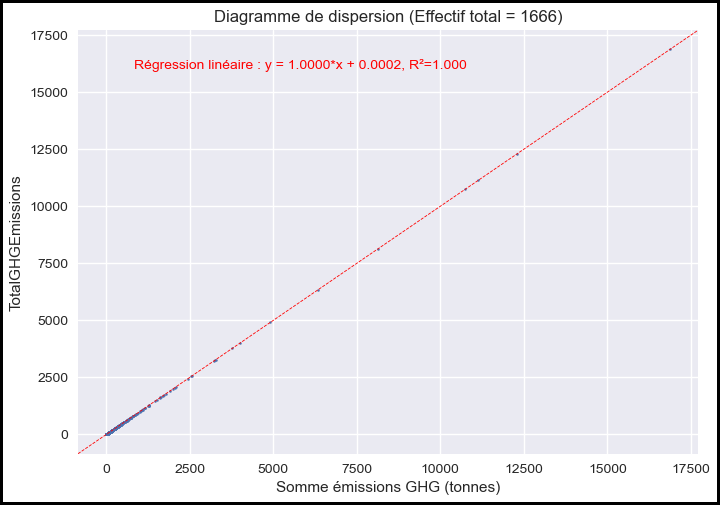

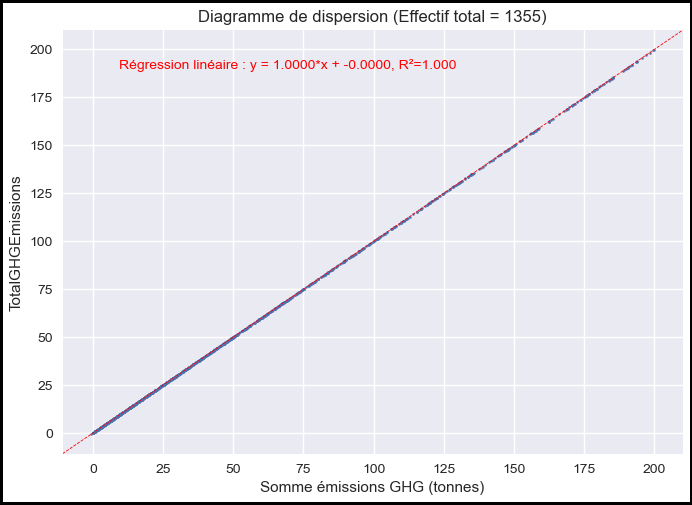

In [231]:
scatter_plot(ser_x=somme_types_emissions, ser_y=df1['TotalGHGEmissions'], alpha=1, ligne_diagonale=False)
scatter_plot(ser_x=somme_types_emissions, ser_y=df1['TotalGHGEmissions'], alpha=1, ligne_diagonale=False, max_x=200, max_y=200)

Corrélation parfaite entre la somme des 3 variables d'émissions d'énergies créées (steam, electricity, natural gas) et la variable TotalGHGEmissions.  
$\Rightarrow$  il suffira de déterminer chaque type d'émission (ou de consommation) pour en déduire TotalGHGEmissions.


### Latitude / longitude

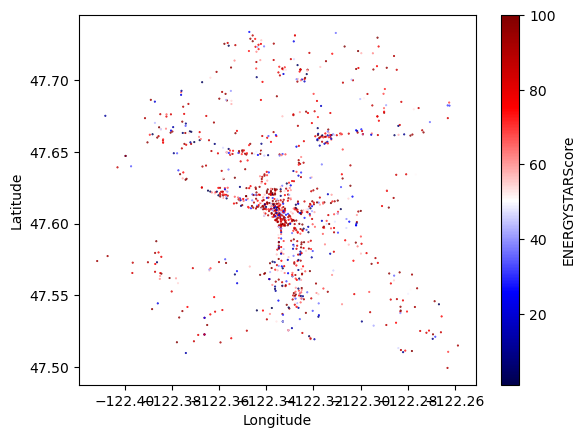

In [232]:
plt.style.use('default')
df1.plot(kind="scatter", x="Longitude", y="Latitude", c='ENERGYSTARScore', label=None, cmap=plt.get_cmap("seismic"), alpha=1, marker='.', s=1);

## Conclusions sur l'analyse exploratoire

### Variables WN (weather normalized)

Elles prennent trop souvent la valeur zéro.  
Après suppression des valeurs fausses zéro, la corrélation avec leur équivalent non WN est très élevée.  
Ces variables ne sont donc pas utilisées pour le modèle prédictif.

Pour le modèle prédictif, on ne retient que les variables suivantes :  
    - set_var_quanti_conservees  
    - set_var_quali

## Sauvegarde du df1 nettoyé

In [233]:
df1.to_pickle('df1_après_nettoyage_Projet_Seattle.pkl')